# Исследование рынка кинопроката

### Описание проекта и постановка задачи

Исследование рынка российского кинопроката за 2015 - 2019 годы. Выявим тренды, отдельное внимание уделим фильмам, которые получили государственную поддержку.
Исходные данные опубликованны на [портале открытых данных](https://opendata.mkrf.ru/) Министерства культуры. Данные содержат информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск (рейтинг).

Данные представлены в двух файлах:

`mkrf_movies.csv` — данные о прокатных удостоверениях
`mkrf_shows.csv`— данные о сборах в прокате в российских кинотеатрах

Предобработка данных включает оптимизацию типов, заполнение пропусков, поиск дубликатов и оптимизацию строковых данных (фильтрация, упорядочивание токенов)

**В рамках исследования ответим на вопросы:**

- Сколько фильмов выходило в прокат каждый год. 
- Как менялась динамика проката по годам. 
- Какова средняя и медианная сумму сборов для каждого года.
- Влияет ли возрастное ограничение аудитории на сборы фильма в прокате
- Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года?
- Исследуем окупаемость фильмов с господдержкой и связь рейтинга фильма с объемом выделяемых средств

### Чтение данных из файлов и объедининение их в один датафрейм. 

Импорт всех необходимых библиотек и функций

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

устанавливаем константы и параметры отображения данных `float`

In [2]:
pd.set_option('display.float_format', '{:.2f}'.format)
DATE_FORMAT_TEMPLATE = '%Y-%m-%dt%H:%M:%S.000z'
RND_ST = 42

Сохраняем датасеты в переменные `data` и `data_show`

In [3]:
data = pd.read_csv('datasets/mkrf_movies.csv')
data_shows = pd.read_csv('datasets/mkrf_shows.csv')

Выведем общую информацию методами `describe()`, `info()` и `sample()`

In [4]:
display(data.describe(include=['float','integer']))
display(data.describe(include=['object']))
data.info()
display(data.sample(5, random_state=RND_ST))

,refundable_support,nonrefundable_support,budget
count,332.00,332.00,332.00
mean,11864457.83,48980988.89,127229716.68
std,24916555.26,59980117.92,188588333.12
min,0.00,0.00,0.00
25%,0.00,25000000.00,42000000.00
50%,0.00,30000000.00,68649916.00
75%,15000000.00,40375000.00,141985319.50
max,180000000.00,400000000.00,2305074303.00


,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,financing_source,ratings,genres
count,7486,7486,7486,7486,7468,7484,7477,6918,7486,332,6519,6510
unique,6772,7484,1965,8,5490,950,4811,5349,5,3,94,742
top,День святого Валентина_,221054410,2010-12-17T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",США,О.Семёнова,П.Смирнов,«16+» - для детей старше 16 лет,Министерство культуры,6.6,драма
freq,5,2,96,4520,341,2172,47,67,2851,164,312,476


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7486 entries, 0 to 7485
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   puNumber               7486 non-null   object 
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
dtypes: f

,title,puNumber,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
2827,Рок на Востоке,121022615,2015-11-09T12:00:00.000Z,Художественный,"Дьюн Филмз, Квед Интертейнмент, Шангри-Ла Инте...",США,Барри Левинсон,"Стив Бинг, Билл Блок, Митч Глейзер",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,5.6,"комедия,военный,музыка"
2858,28 Панфиловцев,111000916,2016-01-27T12:00:00.000Z,Художественный,Индивидуальный Предприниматель Шальопа А.Г.,Россия,"К.Дружинин, А.Шальопа",А.Шальопа,«12+» - для детей старше 12 лет,0.00,30000000.00,85384000.00,Министерство культуры,7.5,"военный,драма,история"
2133,Мой первый раз,121004015,2015-03-05T12:00:00.000Z,Художественный,"Лома Наша, Марс Дистрибусьон, Франс 2 Синема, ...",Франция,Мари-Кастиль Менсьон-Шаар,"Пьер Кюбель, Мари-Кастиль Менсьон-Шаар",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.8,"драма,мелодрама"
5309,Секс в большом городе 2,221090210,2010-10-04T12:00:00.000Z,Художественный,"Нью Лайн Синема, Хоум Бокс Офис, Вилладж Роадш...",США,Майкл Патрик Кинг,"Майкл Патрик Кинг, Сара Джессика Паркер",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.2,"драма,мелодрама,комедия"
3626,Большой собачий побег,124004716,2016-10-12T12:00:00.000Z,Анимационный,Эс Си Фильм Интернэшнл,Канада - Испания,Альберто Родригез,"Джефф Белл, Ибон Корменсана, Филлис Лэйн",«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,5.8,"мультфильм,комедия,приключения"


Выведем общую информацию для `data_show`

In [5]:
display(data_shows.describe())
data_shows.info()
data_shows.sample(5, random_state=RND_ST)

,puNumber,box_office
count,3158.00,3158.00
mean,120187475.32,76478696.16
std,12383941.15,240353122.82
min,111000113.00,0.00
25%,113000191.75,86239.00
50%,121013114.50,2327987.55
75%,121028317.75,23979671.02
max,224026410.00,3073568690.79


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3158 entries, 0 to 3157
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   puNumber    3158 non-null   int64  
 1   box_office  3158 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 49.5 KB


,puNumber,box_office
3053,126004118,1416635.00
2681,124001213,22720.00
2961,126001011,300.00
2335,121027716,30299445.81
139,111002914,7225.00


Приведем названия столбцов к принятому виду, все строковые данные приведем к нижнему регистру, формат даты к типу `datetime`, округлив до дня:

In [6]:
data.rename(columns={'puNumber': 'pu_number'}, inplace=True)
data_shows.rename(columns={'puNumber': 'pu_number'}, inplace=True)

Приводим все строковые данные к нижнему регистру

In [7]:
for item in data.columns:
    try:
        data[item] = data[item].str.lower()
    except:
        pass

Приводим данные к формату datetime с округлением до дня

In [8]:
data['show_start_date'] = pd.to_datetime(data['show_start_date'],
                                         format=DATE_FORMAT_TEMPLATE).dt.round('1D')

Контроль операций

In [9]:
display(data.sample(2))

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
6789,трезвый водитель,111004519,2019-03-21,художественный,"ооо ""кинокомпания ""небо"" по заказу ао ""вбд груп""",россия,р.гигинеишвили,"э.илоян, в.шляппо, д.жалинский, а.троцюк, р.ги...",«16+» - для детей старше 16 лет,0.00,40000000.00,80000000.00,фонд кино,5.1,"комедия,приключения"
6296,"прокуроры 4 ""ограбление века. пропавшие сокров...",112009618,2018-10-16,документальный,"ооо ""фонд национального кино ""патриот""",россия,о.нарлыев,м.журомская,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Объединение таблиц будем делать по столбцу `pu_number`. Тип столбца в `data_movies` строковый, а в `data_shows` целый. Приведем данные в столбце `pu_number` в `data_movies` к числовому типу:

In [10]:
data['pu_number'] = pd.to_numeric(data['pu_number'], errors='coerce')

Проверяем число образовавшихся NaN

In [11]:
print('Кол-во NaN после преобразования:', data['pu_number'].isna().sum())
data[data['pu_number'].isna()]

Кол-во NaN после преобразования: 1


,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,курбан-роман. (история с жертвой),NaN,2014-05-16,художественный,"фонд ""инновация""",россия,с.юзеев,м.галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Посмотрим, есть ли строки с таким же значением `title` или ... например `film_studio`

In [12]:
data[ (data['title'] == data.iloc[1797, 0]) | (data['film_studio'] == data.iloc[1797, 4]) ]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres
1797,курбан-роман. (история с жертвой),NaN,2014-05-16,художественный,"фонд ""инновация""",россия,с.юзеев,м.галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN
2078,курбан-роман. (история с жертвой).,111009614.00,2014-09-03,художественный,"фонд ""инновация""",россия,с.юзеев,м.галицкая,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,NaN,NaN


Строки `1797` и `2078` неявные дубликаты. Удалим `1797`.

In [13]:
data.drop(index=1797, inplace=True)
data.reset_index(drop=True)
print('Кол-во NaN в столбце "pu_number" после удаления строки:', data['pu_number'].isna().sum())

Кол-во NaN в столбце "pu_number" после удаления строки: 0


Преобразуем в тип данных, как у столбца `pu_тumber` в датасете `data_shows`

In [14]:
data['pu_number'] = data['pu_number'].astype(data_shows['pu_number'].dtypes)
data['pu_number'].dtypes

dtype('int64')

Объединяем данные, смотрим сколько значений отсутствует в новом столбце `box_office`

In [15]:
data = data.merge(data_shows, on='pu_number', how='left')
print( f'В столбце "box_office" в "data" отсутствует {data["box_office"].isna().sum()} значений' )

В столбце "box_office" в "data" отсутствует 4327 значений


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7485 non-null   object        
 1   pu_number              7485 non-null   int64         
 2   show_start_date        7485 non-null   datetime64[ns]
 3   type                   7485 non-null   object        
 4   film_studio            7467 non-null   object        
 5   production_country     7483 non-null   object        
 6   director               7476 non-null   object        
 7   producer               6917 non-null   object        
 8   age_restriction        7485 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

#### Вывод

Данные из переменных `data` и `data_show` объединены в один датафрейм `data` по значению номера прокатного удостоверения `pu_number`. Итоговый датафрейм содержит 7485 записей из 16 столбцов. Все строковые данные приведены к нижнему регистру, названия колонок соответствуют принятым правилам. Формат данных в столбце `show_start_date` изменен из типа `float` в тип `datetime` с округлением до дня, тип данных в столбце `pu_number` изменен со строкового на `int64`. В итоговом датафрейме 10 столбцов со строковыми данными типа `object`, 1 столбцец целого типа `int64`, 4 столбца с вещественными данными типа `float64` и 1 столбец с даннымыми формата `datetime`. В 11 столбцах есть пропуски данных.

### Предобработка данных

#### Преобразование типов данных

##### Столбец `pu_number`

Столбец `pu_number` единственный с целым типом данных `int64`. Попробуем оптимизировать тип, применив `pd.to_numeric` с параментром `downcast='unsigned'` так как все значения положительные:

In [17]:
data_int = data.select_dtypes(include=['integer']).apply(pd.to_numeric, downcast='unsigned')
print(data_int.dtypes)

pu_number    uint32
dtype: object


можем преобразовать данные из `int64` в `uint32`:

In [18]:
data['pu_number'] = data['pu_number'].astype(data_int.dtypes['pu_number'])

In [19]:
data['pu_number'].dtypes

dtype('uint32')

##### Столбцы `box_office`, `budget`, `nonrefundable_support`, `refundable_support`

<a id=3_1_2></a>

Все столбцы с типом данных `float64`. Выведем информацию по значениям столбцов:

In [20]:
data[['box_office', 'budget', 'nonrefundable_support', 'refundable_support']].describe()

,box_office,budget,nonrefundable_support,refundable_support
count,3158.00,332.00,332.00,332.00
mean,76478696.16,127229716.68,48980988.89,11864457.83
std,240353122.82,188588333.12,59980117.92,24916555.26
min,0.00,0.00,0.00,0.00
25%,86239.00,42000000.00,25000000.00,0.00
50%,2327987.55,68649916.00,30000000.00,0.00
75%,23979671.02,141985319.50,40375000.00,15000000.00
max,3073568690.79,2305074303.00,400000000.00,180000000.00


столбцы `budget`, `nonrefundable_support`, `refundable_support` содержат одинаковое кол-во значений (и одинаковое построчно-синхронное кол-во пропусков, проверено ниже с помощью функции `check_synchro_nan`). 

В аннотации к данным сказано: `budget` включает в себя полный объём государственной поддержки. Данные в этом столбце указаны только для тех фильмов, которые получили государственную поддержку. Таким образом, можно заполнить пропуски в столбцах `budget`, `nonrefundable_support`, `refundable_support` значением `0`. Фильм не получал господдержку (`nonrefundable_support`, `refundable_support` равны нулю) и значения в `budget` для отсутствующей господдержки по условиям отображения данных не указывается, поэтому `budget` тоже можно указать равным нулю.

In [21]:
def check_synchro_nan(row):
    '''подсчет числа строк, где NaN в столбцах 'budget', 'nonrefundable_support' и 'refundable_support' синхронно'''
    
    return ( (np.isnan(row['budget'])) & (np.isnan(row['nonrefundable_support'])) & (np.isnan(row['refundable_support'])) )
            

print('Число синхронных пропусков:', data.apply(check_synchro_nan, axis=1).sum() )
print(
    'Число пропусков отдельно по столбцам:',
    data['budget'].isna().sum(),
    data['nonrefundable_support'].isna().sum(),
    data['refundable_support'].isna().sum(),
)

Число синхронных пропусков: 7153
Число пропусков отдельно по столбцам: 7153 7153 7153


пропущенные значения целесообразно заменить на ноль.

In [22]:
budget_cols = ['box_office',
               'budget',
               'nonrefundable_support',
               'refundable_support']
data[budget_cols] = data[budget_cols].fillna(0)

In [23]:
data[budget_cols].describe()

,box_office,budget,nonrefundable_support,refundable_support
count,7485.00,7485.00,7485.00,7485.00
mean,32267163.99,5643322.10,2172570.25,526252.51
std,160611080.38,47531308.14,16149994.78,5781491.10
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00
75%,1081445.00,0.00,0.00,0.00
max,3073568690.79,2305074303.00,400000000.00,180000000.00


Выберем все столбцы с типом данных `float`, переведем в тип `uint` т.к. все значения положительные

In [24]:
data_fl = data.select_dtypes(include=['float']).astype('uint')
print(data_fl.dtypes, '\n')

refundable_support       uint32
nonrefundable_support    uint32
budget                   uint32
box_office               uint32
dtype: object 



In [25]:
# меняем типы в столбцах, которые являются индексами в data_fl
# итерируемся по индексам (названия столбцов) и обращаемся к значениям по индексу (тип данных)

for item in data_fl.dtypes.index:
        data[item] = data[item].astype(data_fl.dtypes[item])

In [26]:
data[budget_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   box_office             7485 non-null   uint32
 1   budget                 7485 non-null   uint32
 2   nonrefundable_support  7485 non-null   uint32
 3   refundable_support     7485 non-null   uint32
dtypes: uint32(4)
memory usage: 175.4 KB


In [27]:
data[budget_cols].describe()

,box_office,budget,nonrefundable_support,refundable_support
count,7485.00,7485.00,7485.00,7485.00
mean,32267163.90,5643322.10,2172570.25,526252.51
std,160611080.33,47531308.14,16149994.78,5781491.10
min,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00
75%,1081445.00,0.00,0.00,0.00
max,3073568690.00,2305074303.00,400000000.00,180000000.00


##### Столбец `ratings`

Тип данных в столбце `ratings` строковый, но значения числовые. Как видно из сводки метода `value_counts()` есть значения в формате десятичных значений, а есть в формате процентов. Можно все значения (в том числе и `nan`) из строкового типа перевести в вещественный. Значения с `%` надо интерпретировать как процент от максимального значения рейтинга 10.

In [28]:
data['ratings'].value_counts()

6.6    312
6.7    308
6.8    261
7.2    252
6.2    243
      ... 
19%      1
90%      1
62%      1
64%      1
9.1      1
Name: ratings, Length: 94, dtype: int64

Определим функцию `confert_to_float`, применять функцию будем к `Series`, функция будет получать по одному значению из `Series`. Значения в виде десятичных чисел и 'nan' будем приводить к типу `float` функцией `pd.tu_numeric()`. Для значений с `%` будем делать срез, кроме последнего символа, применять функцию `pd.tu_numeric()` и результат делить на 10. Результат работы функции возвращаем и присваиваем для замены.

In [29]:
def convert_to_float(value):
    try:
        return (pd.to_numeric(value, errors='raise'))
    except:
        return (( pd.to_numeric(value[:-1], errors='coerce') )/10)

In [30]:
data['ratings'] = data['ratings'].apply(convert_to_float)

Проверка преобразования типа данных в столбце:

In [31]:
data['ratings'].dtypes

dtype('float64')

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7485 entries, 0 to 7484
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7485 non-null   object        
 1   pu_number              7485 non-null   uint32        
 2   show_start_date        7485 non-null   datetime64[ns]
 3   type                   7485 non-null   object        
 4   film_studio            7467 non-null   object        
 5   production_country     7483 non-null   object        
 6   director               7476 non-null   object        
 7   producer               6917 non-null   object        
 8   age_restriction        7485 non-null   object        
 9   refundable_support     7485 non-null   uint32        
 10  nonrefundable_support  7485 non-null   uint32        
 11  budget                 7485 non-null   uint32        
 12  financing_source       332 non-null    object        
 13  rat

##### Вывод

Оптимизировали тип данных в столбце `pu_number` из `int64` в `uint32`. 

Вещественный тип `float64` в столбцах `box_office`, `budget`, `nonrefundable_support`, `refundable_support` изменили на целочисленный беззнаковый `uint32`

Строковые данные в столбце `raitings` привели к вещественному типу `float64`

Размер датафрейма уменьшился: с 994.1+ до 847.9+ KB

#### Заполнение пропусков в данных

пропуски в столбцах `box_office`, `budget`, `nonrefundable_support`, `refundable_support` мы заполнили [в разделе 3.1.2](#3_1_2). Посмотрим на пропуски в других столбцах:

In [33]:
def show_nan_prcnt_types(df):
    '''функция подсчета NaN (кол-во и % от всех значений) по столбцам'''
    
    df_nan_prcnt_types = pd.DataFrame(
        data=({
        'value_qty' : [df[column].value_counts().sum() for column in df.columns],
        'NaN_qty': [df[column].isna().sum() for column in df.columns],
        'NaN_prcnt' : [( df[column].isna().sum()/len(df)*100 ) for column in df.columns],
        'data_type' : df.dtypes
        } ),
        index=df.columns
    )

    display(df_nan_prcnt_types.query('NaN_qty != 0').sort_values(by='NaN_qty', ascending=False))

In [34]:
show_nan_prcnt_types(data)

,value_qty,NaN_qty,NaN_prcnt,data_type
financing_source,332,7153,95.56,object
genres,6510,975,13.03,object
ratings,6519,966,12.91,float64
producer,6917,568,7.59,object
film_studio,7467,18,0.24,object
director,7476,9,0.12,object
production_country,7483,2,0.03,object


<a id=3_2_1></a>

##### Столбец `financing_source`

Данные в столбце `financing_source` есть только в тех строках, где есть ненулевое значение либо в столбце `nonrefundable_support` либо в `refundable_support`. Соответственно, в тех строках, где в `financing_source` пропущенные значения - в столбцах `nonrefundable_support` и `refundable_support` стоят нули. Проверяем:

In [35]:
(
    data
    .copy()
    .assign( NaN_financing_source = lambda x: x['financing_source'].isna() )
    .groupby('NaN_financing_source')
    .agg({'nonrefundable_support' : ['min', 'max', 'count'], 'refundable_support' : ['min', 'max', 'count']})
    .sort_values(by='NaN_financing_source', ascending=False)
)

nonrefundable_support                   \
                                       min        max count   
NaN_financing_source                                          
True                                     0          0  7153   
False                                    0  400000000   332   

                     refundable_support                   
                                    min        max count  
NaN_financing_source                                      
True                                  0          0  7153  
False                                 0  180000000   332

заполним пропуски в столбце `financing_source` значением `'отсутствует'`, так как в аннотации к данным сказано, что в этом столбце указывается источник государственного финансирования. Если ничего не указано, то и государственное финансирование - отсутствует.

In [36]:
data['financing_source'] = data['financing_source'].fillna('отсутствует')

посмотрим на значения в столбцах `nonrefundable_support`, `refundable_support` в зависимости от `financing_source` после заполнения пропусков:

In [37]:
(
    data.groupby('financing_source')
    .agg({ 'nonrefundable_support' : ['min', 'max', 'count'], 'refundable_support' : ['min', 'max', 'count'] })
)

nonrefundable_support                   \
                                                   min        max count   
financing_source                                                          
министерство культуры                          3000000   70000000   164   
министерство культуры, фонд кино               5300000  133000000    22   
отсутствует                                          0          0  7153   
фонд кино                                            0  400000000   146   

                                 refundable_support                   
                                                min        max count  
financing_source                                                      
министерство культуры                             0          0   164  
министерство культуры, фонд кино                  0  110000000    22  
отсутствует                                       0          0  7153  
фонд кино                                         0  180000000   146

##### Столбец `genres`

В столбце `genres` целесообразно заполнить пропуски значением `не указан`. В дальнейшем переведем этот столбец в группу категориальных.

In [38]:
data['genres'] = data['genres'].fillna('нет данных')

##### Столбцы  `film_studio`, `production_country`

Указанные столбцы содержат строковые данные и менее 20 пропусков каждый. Заполняем пропуски значением `нет данных`

In [39]:
data[['film_studio', 'production_country']] = data[['film_studio', 'production_country']].fillna('нет данных')

In [40]:
data['film_studio'].isna().sum()

0

в столбце `production_country` есть необычное значение `2019`:

In [41]:
data['production_country'].value_counts().sort_index().head(7)

 ссср                                            2
 ссср                                            1
 ссср                                            1
2019                                             1
cша                                              1
австралия                                       50
австралия - великобритания - бельгия - индия     1
Name: production_country, dtype: int64

In [42]:
data[data['production_country'] == '2019']

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
7246,дело коллини,121027219,2019-09-19,художественный,"константин филм, глобал скрин, севен пикчерз сван",2019,марко кройцпайнтнер,"мартин московиц, кристоф мюллер, марсель хартг...",«16+» - для детей старше 16 лет,0,0,0,отсутствует,7.40,"детектив,драма,криминал",0


это значение можно считать неявным пропуском. Заменим его также на `нет данных`

In [43]:
data.loc[7246, 'production_country'] = 'нет данных'

In [44]:
data[data['title'] == 'дело коллини']

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
7246,дело коллини,121027219,2019-09-19,художественный,"константин филм, глобал скрин, севен пикчерз сван",нет данных,марко кройцпайнтнер,"мартин московиц, кристоф мюллер, марсель хартг...",«16+» - для детей старше 16 лет,0,0,0,отсутствует,7.40,"детектив,драма,криминал",0


##### Столбец `ratings`

В столбце `ratings` 966 пропусков, попробуем восстановить.
Идея состоит в том, что фильм идентифицируется 2-мя основными метриками:
- названием `title`
- студией производства `film_studio`


Нужно сгруппировать `data` по этим параметрам, и для столбца `rating` посчитать: кол-во значений `count`, длину списка группировки `len`.
Если для некого фильма существует ситуация, что в одном месте значение рейтинга пропущено, а в другом - проставлено (т.е. существует значение для восстановления), то будет разница в длине списка группировки `len` и в кол-ве значений `count`. Нам нужно выбрать ситуации, когда:

- кол-во значений > 0 (есть хотя бы одно значение рейтинга для данного фильма)
- длина списка группировки > 1 (есть несколько записей для данного фильма)
- разница м/у длиной списка и кол-вом значений > 0 (среди значений `rating` для данного фильма есть пропуски)

Если же при таких условиях выборка окажется пустой, то востановить пропущенные рейтинги не получится - т.к. нет справочных значений.

<a id=str_filter></a>

Но для начала надо очистить названия фильмов и названия студий от двоеточий, многоточий, кавычек, двойных пробелов и т.п.
Для этого создадим функцию `str_filter` для фильтрации строковых значений.

In [45]:
def str_filter(str_value, chng_d={}, clr_lst=[' ', ',', '.', ':', '_']):
    '''
    функция фильтрации строкового значения
    принимает строку, возвращает строку
    пары для замены передаем в словаре chng_dct
    очистка начала и конца строки по символам в списке clr_lst
    '''
    
    while str_value[0] in clr_lst:
        str_value = str_value[1:]
    while str_value[-1] in clr_lst:
        str_value = str_value[:-1]
    for key in chng_d:
        str_value = str_value.replace(key, chng_d.get(key))
    tokens_lst = str_value.split()
    return ' '.join(tokens_lst)

Помимо очистки строковых данных нужно упорядочить слова (токены) в ячейках. Например, сочетание `"уорнер бразерс, хэйдэй филмз"` и `"хэйдэй филмз, уорнер бразерс"` по смыслу ест одно и то же, а по формальной логике - разное. 

Создадаим функцию `order_str_tokens` для упорядочивания токенов в строковых значениях.

In [46]:
def order_str_tokens(series, div=', '):
    ''' функция для упорядочивания токенов в строковых значения Series'''
    
    return series.apply( lambda x: div.join( sorted(x.split(sep=div)) ) )

<a id=3_2_4_title_studio> </a> 

Столбец с названиями фильмов обработаем только функцией `text_filter`, а столбец c названиями студий последовательно функцией `text_filter` и `order_str_tokens`.

In [47]:
# словарь для замены символов
  
change_dict = {'--'  : ', ',
               ' - ' : '-',
               ',,'  : ', ',
               'ооо ': '',
               'фгуп': '',
               'тпо' : '',
               'зао' : '',
               'ано' : '',
               'ао'  : '',
               'инк' : '',
               '"'   : '',
               ':'   : '',
               '.'   : '',
               ','   : ', ',
               '!'   : '',
               '?'   : '',
               'синэ+ канал+' : 'синэ +, канал +'}

In [48]:
data['title_fltr'] = data['title'].apply(lambda s: str_filter(s, chng_d=change_dict))
data['film_studio_fltr'] = data['film_studio'].apply(lambda s: str_filter(s, chng_d=change_dict))

In [49]:
data['film_studio_fltr'] = order_str_tokens(data['film_studio_fltr'])

In [50]:
group_rating = (
    data.groupby(['title_fltr','film_studio_fltr'])
    .agg( {'ratings' : ['count', len, lambda x: len(x) - x.count()]} )
)

In [51]:
group_rating.head()

ratings  \
                                                                                      count   
title_fltr                       film_studio_fltr                                             
#всё_исправить                   студия ред карпет                                        0   
#москва-руаян                    лева продюксьон                                          0   
#яволонтер истории неравнодушных студия артвидео                                          0   
(не)жданный принц                диджитал фэктори, европа корп, канал +, сине +,...       1   
(не)идеальный мужчина            нон-стоп продакшн                                        1   

                                                                                         \
                                                                                    len   
title_fltr                       film_studio_fltr                                         
#всё_исправить                   студия ред карпет                                    1   
#москва-руаян                    лева продюксьон                                      1   
#яволонтер истории неравнодушных студия артвидео                                      1   
(не)жданный принц                диджитал фэктори, европа корп, канал +, сине +,...   1   
(не)идеальный мужчина            нон-стоп продакшн                                    1   

                                                                                                
                                                                                    <lambda_0>  
title_fltr                       film_studio_fltr                                               
#всё_исправить                   студия ред карпет                                           1  
#москва-руаян                    лева продюксьон                                             1  
#яволонтер истории неравнодушных студия артвидео                                             1  
(не)жданный принц                диджитал фэктори, европа корп, канал +, сине +,...          0  
(не)идеальный мужчина            нон-стоп продакшн                                           0

In [52]:
df_fill_rating = group_rating[(group_rating[('ratings', 'count')] > 0) &
                              (group_rating[('ratings', 'len')] > 1) &
                              (group_rating[('ratings', '<lambda_0>')] > 0)
                             ]
print('Значений для заполнения пропусков в "rating":', len(df_fill_rating))

Значений для заполнения пропусков в "rating": 0


Выборка не содержит результата - дублей для восстановления пропусков нет. Пропуски в `ratings` заполним значением `0`

In [53]:
data['ratings'] = data['ratings'].fillna(0)

##### Столбец `producer`

В столбце 568 пропусков. Попробуем применить логику, аналогичную тому, что мы использовали для `ratings`.

In [54]:
group_producer = (
    data.groupby(['title_fltr','film_studio_fltr'])
    .agg( {'producer' : ['count', len, lambda x: len(x) - x.count()]} )
)

In [55]:
group_producer.head(7)

producer  \
                                                                                       count   
title_fltr                       film_studio_fltr                                              
#всё_исправить                   студия ред карпет                                         1   
#москва-руаян                    лева продюксьон                                           0   
#яволонтер истории неравнодушных студия артвидео                                           1   
(не)жданный принц                диджитал фэктори, европа корп, канал +, сине +,...        1   
(не)идеальный мужчина            нон-стоп продакшн                                         1   
007 координаты скайфолл          данжак, коламбиа пикчерз, метро голдвин майер, ...        1   
007 спектр                       би 24, данджак, коламбиа пикчерз, метро голдвин...        1   

                                                                                         \
                                                                                    len   
title_fltr                       film_studio_fltr                                         
#всё_исправить                   студия ред карпет                                    1   
#москва-руаян                    лева продюксьон                                      1   
#яволонтер истории неравнодушных студия артвидео                                      1   
(не)жданный принц                диджитал фэктори, европа корп, канал +, сине +,...   1   
(не)идеальный мужчина            нон-стоп продакшн                                    1   
007 координаты скайфолл          данжак, коламбиа пикчерз, метро голдвин майер, ...   1   
007 спектр                       би 24, данджак, коламбиа пикчерз, метро голдвин...   1   

                                                                                                
                                                                                    <lambda_0>  
title_fltr                       film_studio_fltr                                               
#всё_исправить                   студия ред карпет                                           0  
#москва-руаян                    лева продюксьон                                             1  
#яволонтер истории неравнодушных студия артвидео                                             0  
(не)жданный принц                диджитал фэктори, европа корп, канал +, сине +,...          0  
(не)идеальный мужчина            нон-стоп продакшн                                           0  
007 координаты скайфолл          данжак, коламбиа пикчерз, метро голдвин майер, ...          0  
007 спектр                       би 24, данджак, коламбиа пикчерз, метро голдвин...          0

In [56]:
df_fill_producer = group_producer[(group_producer[('producer', 'count')] > 0) &
                                  (group_producer[('producer', 'len')] > 1) &
                                  (group_producer[('producer', '<lambda_0>')] > 0)
                                 ]

print('Значений для заполнения пропусков в "producer":', len(df_fill_producer))

Значений для заполнения пропусков в "producer": 0


...к сожалению, заполнить пропуски по такой схеме не получится.

Можно расмотреть два варианта:

- заполнить данные в `producer` значением `"нет данных"`
- заполнить данные в `producer` данными из `director` А почему нет? ... в стобце `director` всего 9  пропусков, значит вероятность того, что там данные найдутся крайне высока. Кроме того - поскольку почти везде указан режиссера фильма, то данные по фильму в части административных должностей вносились. Вероятно, для фильмов, где продюсер не указан, этот функционал совмещался и поэтому данные по этому полю не внесли. Но это равносильно тому, что функционал продюсера выполнял режиссер фильма.

Выбираем 2-й вариант.
Проверим, для всех ли ячеек, где отсутствует значенеи в `producer` найдется значение в `director`:

In [57]:
data[data['producer'].isna() & data['director'].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_fltr,film_studio_fltr
3839,зур концерт (большой концерт).,217027010,2010-06-24,художественный,"ооо ""барс рекордс""",россия,NaN,NaN,«12+» - для детей старше 12 лет,0,0,0,отсутствует,0.00,нет данных,0,зур концерт (большой концерт),барс рекордс
4051,"ганс сэйфуллин ""авылым чишмэлэре. ганс сэйфулл...",217017310,2010-04-23,художественный,"ооо ""барс-рекордс""",россия,NaN,NaN,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,0.00,нет данных,0,ганс сэйфуллин авылым чишмэлэре ганс сэйфуллин...,барс-рекордс
4297,изге вэли (святой валентин),217020610,2010-05-21,художественный,"ооо ""барс рекордс""",россия,NaN,NaN,«12+» - для детей старше 12 лет,0,0,0,отсутствует,0.00,нет данных,0,изге вэли (святой валентин),барс рекордс
4440,мульт личности. выпуск 5,214000410,2010-01-25,художественный,нет данных,нет данных,NaN,NaN,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,4.00,"мультфильм,комедия",0,мульт личности выпуск 5,нет данных


... всего 4 значения, где нет данных ни в `producer` ни в `director`. Итак, заполняем пропуски в `producer` данными из `director`:

In [58]:
(
    data['producer']
    .where( ~(data['producer'].isna() & ~(data['director'].isna())),
           data['director'],
           inplace=True)
)

In [59]:
print( 'Кол-во оставшихся пропусков в столбце "producer":', data['producer'].isna().sum() )

Кол-во оставшихся пропусков в столбце "producer": 4


Теперь посмотрим наоборот - там где есть значение в `producer`, но отсутствует в `director`:

In [60]:
data[ ~(data['producer'].isna()) & data['director'].isna()]

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office,title_fltr,film_studio_fltr
764,"три звезды. концерт в waldbuhne theater, берли...",126003512,2012-12-04,прочие,райзинг алтернатив,великобритания,NaN,вальдбюне театр,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,0.00,нет данных,44350,"три звезды концерт в waldbuhne theater, берлин...",райзинг алтернатив
1735,помпеи. британский музей,126003413,2013-09-12,прочие,"мортускрин, британский музей",великобритания,NaN,британский музей,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,0.00,нет данных,0,помпеи британский музей,"британский музей, мортускрин"
4414,bon jovi. the circle tour,126001710,2010-11-11,прочие,эншутц интертейнмент груп,сша,NaN,эншутц интертейнмент груп,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,7.90,"концерт,музыка",0,bon jovi the circle tour,эншутц интертейнмент груп
4922,георг фридрих гендель. мессия. оратория. корол...,126001111,2011-04-26,прочие,опус арт,великобритания,NaN,короевский колледж кембриджа,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,0.00,нет данных,0,георг фридрих гендель мессия оратория королевс...,опус арт
4941,питер гэбриэл и new blood orchestra 3d,126002711,2011-11-12,прочие,омниверс визион,великобритания,NaN,омниверс визион,«0+» - для любой зрительской аудитории,0,0,0,отсутствует,6.70,"концерт,музыка",0,питер гэбриэл и new blood orchestra 3d,омниверс визион


поступим аналогично - заполним пропуск в `director` значением из `producer`:

In [61]:
(
    data['director']
    .where( ~( ~(data['producer'].isna()) & data['director'].isna() ),
           data['producer'],
           inplace=True)
)

In [62]:
data['director'].isna().sum()

4

Остались по 4 строки в `producer` и `director`, в которых синхронно пропуски. Зполняем их значением `'нет данных'`

In [63]:
data[['producer', 'director']] = data[['producer', 'director']].fillna('нет данных')

##### Вывод

Заполнили все пропуски:

Пропуски (7153) в столбце `financing_source` заполнены значением `"отсутствует"`;

Пропуски (975) в столбце `genres` заполнены значением `"нет данных"`;

Пропуски в столбцах `film_studio` (18),  `production_country`(2)  заполнены значением `"нет данных"`;

Пропуски в столбцах `box_office`, `budget`, `nonrefundable_support`, `refundable_support` заполнены значнием `0` (см. [раздел 2.1.2](#2_1_2))

Пропуски в столбце `producer` (564 / 568) заполнили данными из `director`. Пропуски в столбце `director` (5 / 9) заполнили данными из `producer`.Оставшиеся пропуски в `producer` (4) и `director` (4) заполнили значением `"нет данных"`

Пропуски в столбце `ratings` (966)  заполнили значением `0`.

#### Изучаем дубликаты


Прежде чем приступать к поиску дубликатов, нужно в столбцах, содержащих строковые данные `type`, `production_country`, `director`, `producer`, `age_restriction`, `genres` очистить данные (у нас есть функция `str_filter`) и упорядочить токены в значениях (у нас есть функция `order_str_tokens`).

<a id=3_3_1></a>

##### Фильтрация в столбцах `type` и `age_restriction`

В этих столбцах уникальных значений мало. Столбец `age_restriction` не нуждается в обработке - там всего 5 уникальных значаний. В столбце `type` для единообразия нужно убрать пробелы в начале слов.

In [64]:
data['age_restriction'].value_counts()

«16+» - для детей старше 16 лет           2851
«18+» - запрещено для детей               1605
«12+» - для детей старше 12 лет           1592
«0+» - для любой зрительской аудитории     811
«6+» - для детей старше 6 лет              626
Name: age_restriction, dtype: int64

In [65]:
data['type'].value_counts()

художественный                4519
 художественный               1389
анимационный                   828
прочие                         406
документальный                 288
научно-популярный               53
 анимационный                    1
музыкально-развлекательный       1
Name: type, dtype: int64

In [66]:
data['type_fltr'] = data['type'].str.strip()
data['type_fltr'].value_counts()

художественный                5908
анимационный                   829
прочие                         406
документальный                 288
научно-популярный               53
музыкально-развлекательный       1
Name: type_fltr, dtype: int64

<a id=3_3_2></a>

##### Фильтрация + упорядочивание в столбцах `production_country`, `director`, `producer`, `genres`

В этих столбцах алгоритм одинаковый: применяем фильтрацию `str_filter` и упорядочивание `order_str_tokens`. Разница будет только в используемых словарях для фильтрации.

In [67]:
change_dict_1 = {' - - ' : ', ',
                 ' - '   : ', ',
                 '-'     : ', ',
                 ',,'    : ', ', 
                 ';'     : '',
                 'cша'   : 'сша',
                 'сща'   : 'сша',
                 'норвения' : 'норвегия',
                 'бенльгия' : 'бельгия',
                 'босния,герцеговина' : 'босния-герцеговина',
                 'пуэрто,рико' : 'пуэрто-рико'}

change_dict_2 = {','  : ', ',
                 '-'  : ', ',
                 ',,' : ', ', 
                 ';'  : ', '}

change_dict_3 = {':'   : '',
                 ','   : ', ',
                 '!'   : '',
                 '?'   : '',
                 'ооо' : '',
                 'фгуп': '',
                 '"'   : ''}

columns_dict = {'production_country' : 'production_country_fltr',
                'genres' : 'genres_fltr',
                'director' : 'director_fltr',
                'producer' : 'producer_fltr'}

change_dicts_list = [change_dict_1, change_dict_2, change_dict_3, change_dict_3]

In [68]:
def filter_and_order(col_dict, ch_list):
    ch_dict_indx = 0
    for key in col_dict:
        data[col_dict.get(key)] = data[key].apply( lambda s: str_filter(s, chng_d=ch_list[ch_dict_indx]) )
        data[col_dict.get(key)] = order_str_tokens(data[col_dict.get(key)])
        ch_dict_indx += 1

In [69]:
filter_and_order(columns_dict, change_dicts_list)

Выше мы обработали столбец `type`, а в разделе [3.2.4](#3_2_4_title_studio) мы обработали также столбцы `title` и `film_studio`. Выведем статистику по всем столбцам, которые мы подвергли фильтрации и упорядочиванию:

In [70]:
stat_dict_columns = {
    'title' : 'title_fltr',
    'film_studio' : 'film_studio_fltr',
    'type' : 'type_fltr',
    'production_country' : 'production_country_fltr',
    'genres' : 'genres_fltr',
    'director' : 'director_fltr',
    'producer' : 'producer_fltr'
}

stat_dict = {}

for key in stat_dict_columns:
    stat_dict[key] =  ( len(data[key].value_counts()), len(data[stat_dict_columns.get(key)].value_counts()), 0, 0) 

df_filter_order_stat = pd.DataFrame(
    stat_dict,
    index=('Уникальных знач. до обработки',
           'Уникальных знач. после обработки',
           'Разница',
           'Процент изменения')
)
    
for col in range(len(stat_dict_columns)):
    df_filter_order_stat.iloc[2, col] = df_filter_order_stat.iloc[1, col] - df_filter_order_stat.iloc[0, col]
    df_filter_order_stat.iloc[3, col] = '{:.1%}'.format(df_filter_order_stat.iloc[2, col] / df_filter_order_stat.iloc[0, col])
        
df_filter_order_stat.T.sort_values('Процент изменения', ascending=False)

,Уникальных знач. до обработки,Уникальных знач. после обработки,Разница,Процент изменения
genres,743,474,-269,-36.2%
production_country,949,673,-276,-29.1%
type,8,6,-2,-25.0%
title,6761,6658,-103,-1.5%
film_studio,5451,5372,-79,-1.4%
producer,5706,5659,-47,-0.8%
director,4812,4795,-17,-0.4%


Как видим, фильтрация и упорядочивание дали разный эффект снижения количества уникальных значений в столбцах:

- в столбцах `type`, `production_country` и `genres` эффект значительный и измеряется десятками процентов
- в `title`, `film_studio` эффект слабый - измеряется чуть более 1-го процента
- в `director` и `producer` эффекта почти нет - доли процента.

Столбцы с обработанными данными имеют суффикс `_fltr`

##### Проверка на дубликаты

Создадаим `data_fltr` содержащий обработанные столбцы, вместо изначальных:

In [71]:
data_fltr = data[[
    'title_fltr', 'pu_number', 'show_start_date',
    'type_fltr', 'film_studio_fltr', 'production_country_fltr',
    'director_fltr', 'producer_fltr', 'age_restriction',
    'refundable_support', 'nonrefundable_support', 'budget',
    'financing_source', 'ratings', 'genres_fltr', 'box_office'
]]

###### Проверка на явные дубликаты:

In [72]:
data_fltr.duplicated().sum()

0

###### Проверка на неявные дубликаты исключением комбинаций столбцов

Убрав из рассмотрения `pu_number` обнаружилось 7 дубликатов:

In [73]:
data_fltr[data_fltr.columns.drop('pu_number')].duplicated().sum()

7

Если убрать `pu_number` и `show_start_date` то дубликатов стало 497 (+490). А вариант, когда убираем `show_start_date`, но оставляем `pu_number`, не дает дубликатов:

In [74]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date']) ].duplicated().sum()

497

In [75]:
data_fltr[ data_fltr.columns.drop(['show_start_date']) ].duplicated().sum()

0

**Комбинация** *['pu_number', 'show_start_date',* **`producer_fltr`** ] **дает 1 доп. дубликат:**

In [76]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date', 'producer_fltr']) ].duplicated().sum()

498

Посмотрим, что за фильм вносит дополнительный дубликат:

In [77]:
def show_difference(col_name):
    '''функция возвращает датафрейм с дубликатами, которые появились при исключении колонки col_name'''
    
    dfr_1 = data_fltr[ data_fltr[data_fltr.columns.drop(['pu_number', 'show_start_date'])].duplicated() ]
    dfr_2 = data_fltr[ data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date', col_name]) ].duplicated() ]
    diff = pd.concat([dfr_1, dfr_2]).drop_duplicates(keep=False)
    return diff

In [78]:
diff_prd = show_difference('producer_fltr')
display(diff_prd)

,title_fltr,pu_number,show_start_date,type_fltr,film_studio_fltr,production_country_fltr,director_fltr,producer_fltr,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres_fltr,box_office
4017,тайна красной планеты,124000511,2011-03-09,анимационный,"имиджмуверс, ступид манки, уильямс стрит, уолт...",сша,саймон уэллс,"джек рапке, роберт земекис, стив джей бойд, ст...",«0+» - для любой зрительской аудитории,0,0,0,отсутствует,6.10,"боевик, мультфильм, фантастика",0


Посмотрим на значения в ячейке `producer_fltr` для фильма из `diff_prd`:

In [79]:
data_fltr[data_fltr['title_fltr'] == diff_prd.iloc[0,0]]['producer_fltr'].value_counts()

джек рапке, роберт земекис, стив старки, стивен джей бойд    1
джек рапке, роберт земекис, стив джей бойд, стив старки      1
Name: producer_fltr, dtype: int64

Сделаем значение в поле `producer_fltr` одинаковым, причем как в `data` так и в `data_fltr` (значение возьмем из `diff_prd`):

In [80]:
for indx in data_fltr[data_fltr['title_fltr'] == diff_prd.iloc[0,0]].index:
    data_fltr.loc[indx, 'producer_fltr'] = diff_prd.iloc[0,7]
    data.loc[indx, 'producer_fltr'] = diff_prd.iloc[0,7]

Проверяем:

In [81]:
data_fltr[data_fltr['title_fltr'] == diff_prd.iloc[0,0]]['producer_fltr'].value_counts()

джек рапке, роберт земекис, стив джей бойд, стив старки    2
Name: producer_fltr, dtype: int64

In [82]:
data[data['title_fltr'] == diff_prd.iloc[0,0]]['producer_fltr'].value_counts()

джек рапке, роберт земекис, стив джей бойд, стив старки    2
Name: producer_fltr, dtype: int64

Теперь подсчет дубликатов без включения `producer_fltr` дает 8 и 498:

In [83]:
data_fltr[ data_fltr.columns.drop('pu_number') ].duplicated().sum()

8

In [84]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date']) ].duplicated().sum()

498

**Комбинация** *['pu_number', 'show_start_date',* **`film_studio_fltr`** ] **дает 1 доп. дубликат:**

In [85]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date', 'film_studio_fltr' ]) ].duplicated().sum()

499

Сделаем значение в поле `film_studio_fltr` одинаковым, причем как в `data` так и в `data_fltr` (значение возьмем из `diff_stud`):

In [86]:
diff_stud = show_difference('film_studio_fltr')
display(diff_stud)

,title_fltr,pu_number,show_start_date,type_fltr,film_studio_fltr,production_country_fltr,director_fltr,producer_fltr,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres_fltr,box_office
6551,аниматор,111024818,2018-12-27,художественный,фаворит медиа,россия,"а.чижиков, и.чижиков","а.чижиков, н.чижикова",«12+» - для детей старше 12 лет,0,0,0,отсутствует,0.00,нет данных,0


In [87]:
for indx in data_fltr[data_fltr['title_fltr'] == diff_stud.iloc[0,0]].index:
    data_fltr.loc[indx, 'film_studio_fltr'] = diff_stud.iloc[0,4]
    data.loc[indx, 'film_studio_fltr'] = diff_stud.iloc[0,4]

In [88]:
data_fltr[data_fltr['title_fltr'] == diff_stud.iloc[0,0]]['film_studio_fltr'].value_counts()

фаворит медиа    2
Name: film_studio_fltr, dtype: int64

Теперь подсчет дубликатов без включения `film_studio_fltr` дает 8 и 499:

In [89]:
data_fltr[ data_fltr.columns.drop('pu_number') ].duplicated().sum()

8

In [90]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date']) ].duplicated().sum()

499

**Комбинация** *['pu_number', 'show_start_date',* **`age_restriction`** ] **дает 5 доп. дубликатов:**

In [91]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date', 'age_restriction']) ].duplicated().sum()

504

Посмотрим подробнее:

In [92]:
diff_age = show_difference('age_restriction')

In [93]:
age_restr_diff = (
    data_fltr[ data_fltr['title_fltr'].isin(diff_age['title_fltr'])]
    [['pu_number', 'show_start_date', 'title_fltr', 'age_restriction']]
    .sort_values(by='title_fltr')
)

display(age_restr_diff)

,pu_number,show_start_date,title_fltr,age_restriction
1831,121001914,2014-02-07,300 спартанцев расцвет империи /по произведени...,«16+» - для детей старше 16 лет
2093,221014914,2014-05-28,300 спартанцев расцвет империи /по произведени...,«18+» - запрещено для детей
1432,221053014,2014-11-06,забойный реванш,«16+» - для детей старше 16 лет
1433,121031213,2013-12-03,забойный реванш,«16+» - для детей старше 16 лет
2092,221012914,2014-04-08,забойный реванш,«18+» - запрещено для детей
6684,111002119,2019-02-13,любовницы,«18+» - запрещено для детей
6748,111003519,2019-03-01,любовницы,«16+» - для детей старше 16 лет
1273,121010314,2014-05-30,неудержимые 3,«12+» - для детей старше 12 лет
1905,221047214,2014-10-21,неудержимые 3,«16+» - для детей старше 16 лет
449,221019512,2012-02-28,схватка,«16+» - для детей старше 16 лет


Один и тот же фильм получал в разное время разные прокатные удостоверения с разным возрастным ограничением. Вероятно, это разные версии фильма или ограничения пересматривались при выдаче прокатного удостоверения. Точная причина таких разночтений не понятна. Фильмы, для которых выявлены различия в присвоении возрастных ограничений, у нас сохранены в переменной `age_restr_diff`.

**Комбинация** *['pu_number', 'show_start_date',* **`box_office`** ] **дает 181 доп. дубликат:**

In [94]:
data_fltr[ data_fltr.columns.drop(['pu_number', 'show_start_date', 'box_office']) ].duplicated().sum()

680

Тут все довольно прозрачно - сборы в кинотеатрах указаны для конкретного номера прокатного удостоверения (данные из `mkrf_shows`). Поскольку на один и тот же фильм выдается несколько прокатных удостоверений, то при исключении столбца `box_office` появляются дубликаты.

##### Вывод

<a id=duplicates></a>

Явных дубликатов нет.


Неявные дубликаты:

- 8 фильмов отличаются только номером прокатного удостоверения. Прокатное удостоверение выдается конкретному заявителю (физ. или юр. лицо) и дает право на прокат фильма. Такие неявные дубликаты оставляем.


- 499 фильмов отличается датами премьеры и номерами прокатных удостоверений (т.к. исключение только `show_start_date` без исключения `pu_number` не приводит к дубликатам). Вероятно, дата премьеры - это дата начала проката при получении прокатного удостоверения. Поэтому разные заявители получали на один и тот же фильм прокатное удостоверение с разной датой начала проката. Такие неявные дубликаты оставляем.


- 5 фильмов имеют разные категории возрастного ограничения. Оставляем, так как не понятно: это ошибки в данных или это разные версии фильма.


- 181 фильм отличается данными по сборам в кинотеатрах. Это вызвано тем, что сборы указываются для конкретного номера прокатного удостоверения. Один и тот же фильм мог получать разные прокатные удостоврения в разные годы и показывать разные сборы в кинотеатрах в период действия этого прокатного удостоверения.

#### Анализ категориальных значений

К категориальным столбцам можно отнести:


- `type` тип фильма,
- `production_country` страна производства,
- `age_restriction` возрастная категория,
- `financing_source` источник государственного финансирования
- `genres` жанр фильма


Значения в столбце `type` мы исправили в разделе [3.3.1](#3_3_1). Исправленные значения сохранили в новый столбце `type_fltr`. 
Значения в столбцах `genres` и `production_country` мы отфильтровали и упорядочили в разделе [3.3.2](#3_3_2), исправленные значения сохранили в новых столбцах `genres_fltr` и `production_country_fltr` соответственно.

Столбцы `age_restriction` и `financing_source` содержали хорошие данные. В столбце `financing_source` мы произвели заполнение пропусков значением `'отсутствует'` в разделе [3.2.1](#3_2_1)

##### Вывод

Общая проблема не только в категориальных столбцах, но и в целом в столбцах со строковыми данными - это то, что данные содержат много "мусора", который формально делает одни и те же значения разными. Также неупорядоченность вносит формальную разницу в значения. Все эти проблемы устранены и обработанные данные содержатся в переменной `data_fltr`

#### Анализ количественных значений

##### Столбец `budget`

Cтолбцы `budget`, `nonrefundable_support`, `refundable_support` содержат одинаковое кол-во построчно синхронных значений (проверили в разделе [3.1.2](#3_1_2))

Исходя из аннотации к данным (`столбец budget уже включает в себя полный объём государственной поддержки`) сумма значений в столбцах `nonrefundable_support` и `refundable_support` должна быть не более, чем значение в столбце `budget`.

Проверим, встречаются ли такие ситуации и, если встречаются, то заменим значение в `budget` на сумму значений из `nonrefundable_support` и `refundable_support`

In [95]:
(
    data_fltr.apply(
        lambda df:
        False if ( (df['nonrefundable_support'] + df['refundable_support']) <= df['budget'] )
        else True,
        axis=1)
        .sum()
)

17

Замена значений в столбце `budget` по условию

In [96]:
(
    data_fltr['budget']
    .where((data_fltr['nonrefundable_support'] + data_fltr['refundable_support']) <= data_fltr['budget'],
           (data_fltr['nonrefundable_support'] + data_fltr['refundable_support']),
           inplace=True
          )
)

Проверка результатов замены

In [97]:
data_fltr.apply(
    lambda df: 
    False if ((df['nonrefundable_support'] + df['refundable_support']) <= df['budget']) else True,
    axis=1
).sum()

0

##### Вывод

К столбцам с числовыми значениями относятся:

In [98]:
for item in list(data_fltr.select_dtypes(include=['integer', 'float']).columns):
    print(item)

pu_number
refundable_support
nonrefundable_support
budget
ratings
box_office


во всех столбцах, кроме столбца `budget` значения без аномалий. В столбце `budget` исправлены 17 значений, т.к. бюджет был меньше, чем сумма источников.

#### Добавление новых столбцов

##### Год проката

Выделим год в датафреймах `data` и `data_fltr`, запишем значение в новый столбец `show_start_year`:

In [99]:
data = data.assign( show_start_year = lambda x: pd.DatetimeIndex(x['show_start_date']).year)
data_fltr = data_fltr.assign( show_start_year = lambda x: pd.DatetimeIndex(x['show_start_date']).year)
display(data.head(2))
display(data_fltr.head(2))

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,...,genres,box_office,title_fltr,film_studio_fltr,type_fltr,production_country_fltr,genres_fltr,director_fltr,producer_fltr,show_start_year
0,открытый простор,221048915,2015-11-27,художественный,"тачстоун пикчерз, кобальт пикчерз, бикон пикче...",сша,кевин костнер,"дэвид валдес, кевин костнер, джейк эбертс",«18+» - запрещено для детей,0,...,"боевик,драма,мелодрама",0,открытый простор,"бикон пикчерз, кобальт пикчерз, тачстоун пикче...",художественный,сша,"боевик, драма, мелодрама",кевин костнер,"джейк эбертс, дэвид валдес, кевин костнер",2015
1,особо важное задание,111013716,2016-09-14,художественный,"киностудия ""мосфильм""",ссср,е.матвеев,е.матвеев,«6+» - для детей старше 6 лет,0,...,"драма,военный",0,особо важное задание,киностудия мосфильм,художественный,ссср,"военный, драма",е.матвеев,е.матвеев,2016


,title_fltr,pu_number,show_start_date,type_fltr,film_studio_fltr,production_country_fltr,director_fltr,producer_fltr,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres_fltr,box_office,show_start_year
0,открытый простор,221048915,2015-11-27,художественный,"бикон пикчерз, кобальт пикчерз, тачстоун пикче...",сша,кевин костнер,"джейк эбертс, дэвид валдес, кевин костнер",«18+» - запрещено для детей,0,0,0,отсутствует,7.20,"боевик, драма, мелодрама",0,2015
1,особо важное задание,111013716,2016-09-14,художественный,киностудия мосфильм,ссср,е.матвеев,е.матвеев,«6+» - для детей старше 6 лет,0,0,0,отсутствует,6.60,"военный, драма",0,2016


##### ФИО режиссера, жанр

Создадим два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

Создадам функцию, которая будет получать строку и возвращать первое значение. Разделитель будет запятая. Применим также функцию [str_filter](#str_filter), которую использовали для очистки пунктуации в начале строки.

In [100]:
# получаем Series, далее последовтельно к каждому значению в Series
# применяем .strip(), чтоб убрать пробелы в начале и в конце
# применяем функцию str_filter(), чтоб очистить значаение от запятых, двоеточий и т.п. в начале
# методом split(',', 1) делим строку на 2 части, начиная слева, разделитель запятая
# метод split возвращает список, берем из списка первое значение (индекс 0)
# возвращаем новую Series

def get_first_split(serial_val):
    return serial_val.apply( lambda str_val: str_filter( str_val.strip() ).split(',', 1)[0] )

Применим функцию `get_first_split` к столбцам `director` и `genres` в датасете `data`, сохранив значения в столбцы `director_main`, `genre_main`:

In [101]:
data = data.assign(
    director_main = lambda x: get_first_split(x['director']),
    genres_main = lambda y: get_first_split(y['genres'])
)

data[['genres', 'genres_main', 'director', 'director_main']][120:126]

,genres,genres_main,director,director_main
120,"ужасы,триллер,драма",ужасы,"дэнни панг, оксид панг",дэнни панг
121,"фэнтези,приключения,семейный",фэнтези,майк ньюэлл,майк ньюэлл
122,"фэнтези,приключения,семейный",фэнтези,майк ньюэлл,майк ньюэлл
123,"драма,криминал,спорт",драма,ди.джи.карузо,ди.джи.карузо
124,"документальный,короткометражка",документальный,"эл гиддингс, дэвид кларк",эл гиддингс
125,"ужасы,триллер,драма",ужасы,"дэвид моро, хавьер палю",дэвид моро


### Исследовательский анализ данных

<a id=gov_supp></a>

##### Господдержка

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

Сохраним данные, необходимые для работы, в переменную `data_budget`. Выберем столбцы `'title_fltr', 'refundable_support', 'nonrefundable_support', 'budget'` и строки, где значение в `budget` больше нуля. Выведем информацию по датасету `data_budget` и проверим на наличие дубликатов:

In [102]:
data_budget = data_fltr[['title_fltr', 'refundable_support', 'nonrefundable_support', 'budget']].query('budget > 0').copy()
data_budget.info()

print('\n найдено дубликатов:', data_budget.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 1281 to 7477
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   title_fltr             332 non-null    object
 1   refundable_support     332 non-null    uint32
 2   nonrefundable_support  332 non-null    uint32
 3   budget                 332 non-null    uint32
dtypes: object(1), uint32(3)
memory usage: 9.1+ KB

 найдено дубликатов: 0


Создадим столбец `gov_support_prcnt` со значением % гос. поддержки в бюджете фильма:

In [103]:
data_budget = (
    data_budget
    .assign(gov_support_prcnt = lambda df: round(
        ((df['refundable_support'] + df['nonrefundable_support']) / df['budget'] * 100), 2)
           )      
)

<a id=describe_apply></a>

Воспользуемся `.describe()` для подробного описания значений:

In [104]:
data_budget.describe()

,refundable_support,nonrefundable_support,budget,gov_support_prcnt
count,332.00,332.00,332.00,332.00
mean,11864457.83,48980988.89,131422395.80,54.21
std,24916555.26,59980117.92,187148242.67,19.69
min,0.00,0.00,6000000.00,4.40
25%,0.00,25000000.00,45524799.50,38.46
50%,0.00,30000000.00,71196901.50,61.41
75%,15000000.00,40375000.00,150000000.00,66.14
max,180000000.00,400000000.00,2305074303.00,100.00


In [105]:
(
    data_budget
    .groupby(pd.cut(data_budget['gov_support_prcnt'], [0, 10, 25, 50, 75, 90, 100]))
    .agg(films_qty=('title_fltr', 'count'))
)

,films_qty
gov_support_prcnt,
"(0, 10]",4
"(10, 25]",25
"(25, 50]",95
"(50, 75]",190
"(75, 90]",1
"(90, 100]",17


**Вывод:** 

Господдержка занимает в бюджетах фильмов от 4.4% до 100%. В среднем гос. поддержка составляет 54.21%.


В разрезе количества фильмов:
- 25% фильмов получили до 38.46% средств гос. поддержки
- 50% фильмов получили до 61.41% средств гос. поддержки
- 75% фильмов получили до 66.14% средств гос. поддержки


В разрезе объема финансирования:
- 10% поддержки или менее получили 4 фильма
- от 10% до 25% поддержки получили 25 фильмов
- от 25% до 50% поддержки получили 95 фильмов
- от 50% до 75% поддержки получили 190 фильмов. Это самая большая группа.
- от 75% до 90% поддержки получил только 1 фильм.
- от 90% до 100% поддержки получили 17 фильмов

#### Кол-во фильмов в прокате по годам

<a id=4_1><a/>

- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

Для подсчета кол-ва фильмов, которые выходили в прокат каждый год, нам нужны группировки по годам с агрегированием по кол-ву фильмов (т.е. по названию `title_fltr`). Если в рамках одной группировки фильм с одним и тем же названием будет встречаться несколько раз, то мы получим неверные данные. Поэтому нам нужно:

- выбрать только столбцы `title_fltr`, `show_start_year`
- избавиться от дубликатов
- провести группировку по столбцу `show_start_year`
- агрегировать данные по кол-ву в столбце `title_fltr`

In [106]:
films_per_year = (
    data_fltr[['title_fltr', 'show_start_year']]
    .drop_duplicates()
    .groupby('show_start_year')
    .agg(films_qty =('title_fltr' , 'count'))
)

films_per_year.T

show_start_year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
films_qty,815,554,547,616,753,686,779,505,883,925


Для подсчета кол-ва фильмов, по которым известны данные по прокату в кинотеатрах, нужно сделать все то же самое, но предварительно добавить условие, что значение в `box_office` > 0

In [107]:
films_per_year_box = (
    data_fltr[data_fltr['box_office'] > 0]
    .drop_duplicates()
    .groupby('show_start_year')
    .agg(films_box_known_qty =('title_fltr' , 'count'))
)

films_per_year_box.T

show_start_year,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
films_box_known_qty,101,109,122,180,273,462,525,357,475,530


Теперь можно объединить данные и:

+ рассчитать % фильмов по годам, для которых есть данные о сборах
+ добавить результат по всем данным

In [108]:
films_per_year_final = (
    films_per_year.join(films_per_year_box)
    .sort_index(ascending=False)
    .apply(lambda col: col.append(col.agg({'total' : 'sum'})))
    .assign(box_known_pcnt = lambda x: x['films_box_known_qty']/x['films_qty']*100)
)

films_per_year_final

,films_qty,films_box_known_qty,box_known_pcnt
2019,925,530,57.30
2018,883,475,53.79
2017,505,357,70.69
2016,779,525,67.39
2015,686,462,67.35
2014,753,273,36.25
2013,616,180,29.22
2012,547,122,22.30
2011,554,109,19.68
2010,815,101,12.39


Построим гистограмму по получившимся данным (кроме `total`):

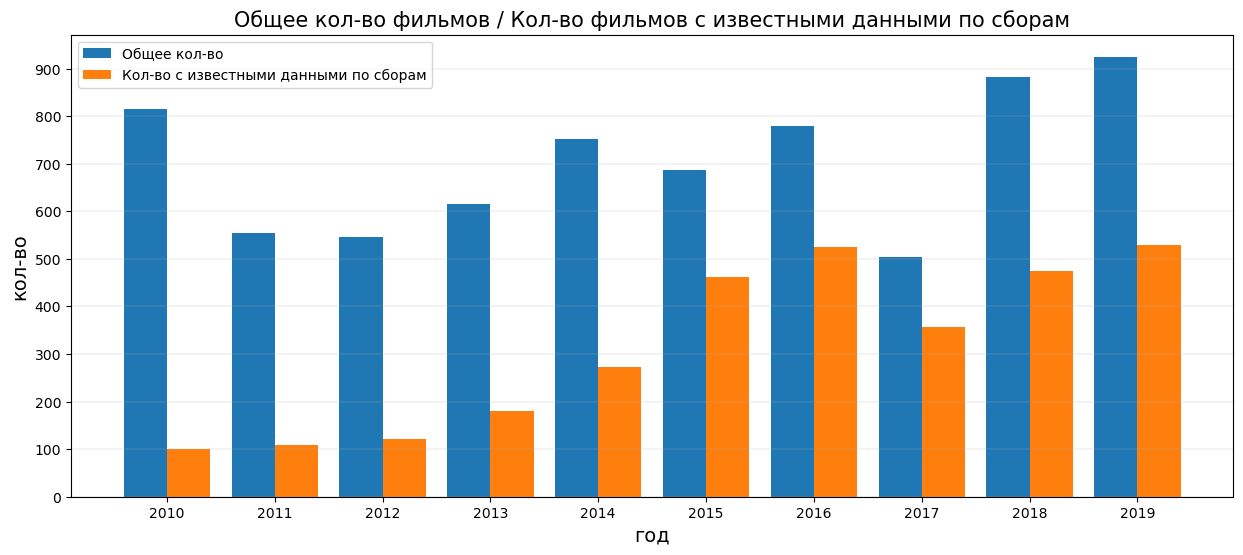

In [109]:
fig, ax = plt.subplots()

x1 = films_per_year_final.index[:-1] - 0.2
x2 = films_per_year_final.index[:-1] + 0.2

y1 = films_per_year_final['films_qty'][:-1]
y2 = films_per_year_final['films_box_known_qty'][:-1]

ax.bar(x1, y1, width = 0.4, label = 'Общее кол-во')
ax.bar(x2, y2, width = 0.4, label = 'Кол-во с известными данными по сборам')
ax.legend()

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.grid(axis = 'y', linewidth = 0.2)

ax.set_title('Общее кол-во фильмов / Кол-во фильмов с известными данными по сборам', fontsize=15)
ax.set_xlabel('год', fontsize=14)
ax.set_ylabel('кол-во', fontsize=14)

fig.set_figwidth(15) 
fig.set_figheight(6)

plt.show()



##### Вывод

Всего за 2010 - 2019 в прокат вышло 7063 фильма. Макс. кол-во фильмов (925) вышло в прокат в 2019 году, мин. кол-во фильмов (505) вышло в прокат в 2017 году.



Данные по прокату в кинотеатрах в среднем известны для 44,37% фильмов, выходящих в прокат. Минимальный % фильмов с известными сборами (12,39%) был в 2010 году, максимальный % фильмов с известными сборами (70,69%) был в 2017 году

#### Динамика проката по годам

<a id=4_2><a/>

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

Выберем только столбцы `show_start_year` и `box_office`. Сгруппируем данные по годам и аггрегируем по сумме значений в `box_office` в миллионах. Там, где сборы не известны, стоят нули и это не повлияет на значение суммы.

In [110]:
box_per_year = (
    data_fltr[['show_start_year', 'box_office']]
    .groupby('show_start_year')
    .agg(year_box_office_M = ('box_office', lambda x: sum(x)/1000000))
)
                                                   
box_per_year.sort_values('year_box_office_M', ascending=False)

,year_box_office_M
show_start_year,
2018,49668.40
2017,48563.71
2019,48425.71
2016,47866.30
2015,39497.37
2014,7444.95
2013,29.80
2011,14.10
2012,6.95


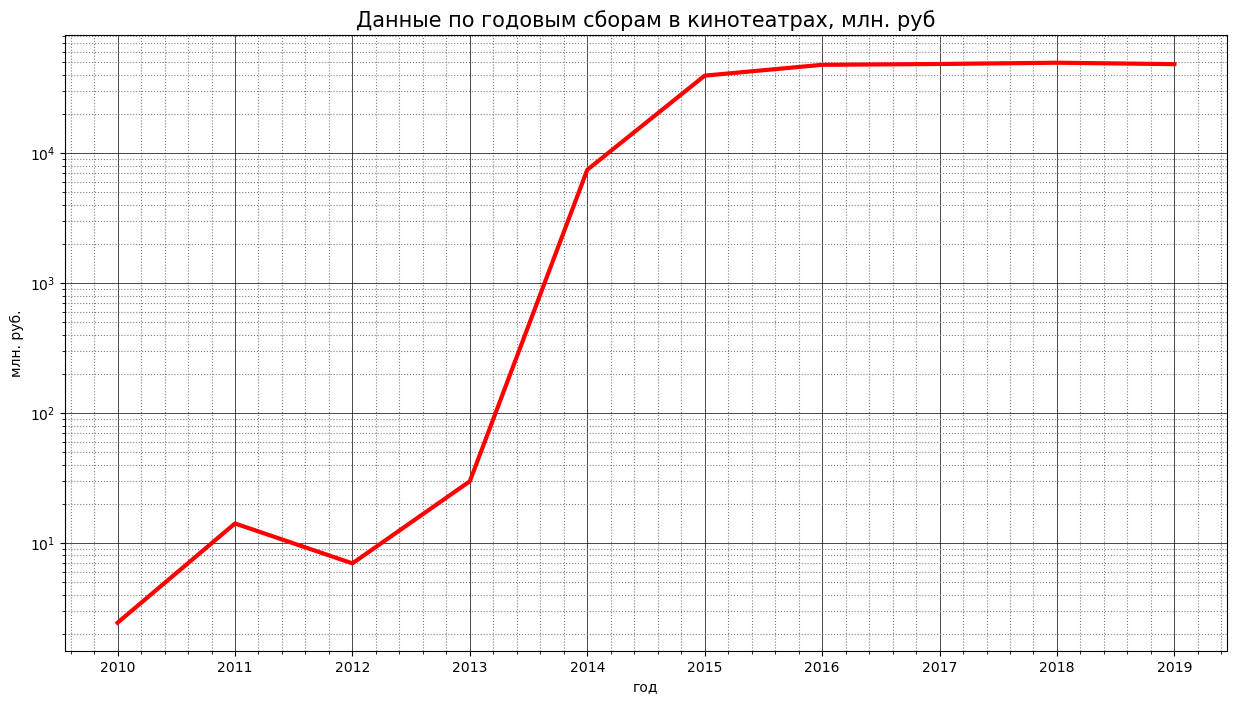

In [111]:
fig, ax = plt.subplots()

x = box_per_year.index
y = box_per_year['year_box_office_M']

ax.plot(x, y, color = 'r', linewidth = 3)

ax.set_yscale('log')

ax.minorticks_on()

ax.grid(which='major',
        color = 'k', 
        linewidth = .5)

ax.grid(which='minor', 
        color = 'grey', 
        linestyle = ':')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_title('Данные по годовым сборам в кинотеатрах, млн. руб', fontsize=15)
ax.set_xlabel('год')
ax.set_ylabel('млн. руб.')

fig.set_figwidth(15) 
fig.set_figheight(8)

plt.show()

##### Вывод

Динамика проката показывала рост/спад в период 2010-2011-2012. Начиная с 2012 начался очень крутой рост вплоть до 2015 года. За этот период сборы выросли с 7 млн. руб. до почти 39,5 млрд. руб. Начиная с 2015 и до 2018 темп рост стал умеренный и сборы выросли до 49,7 млрд. руб. В 2019 году был небольшой спад до значения 48,4 млрд. руб.


Минимальные сборы были зафиксированы в 2010 году (2,43 млн руб.), максимальные - в 2018 году (49 668 млн. руб.)

#### Среднее и медианное значение сборов по годам

<a id=4_3><a/>

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

Чтоб не искажать расчеты, выберем только те данные, где есть значение в столбце `box_office`.

In [112]:
# значения в тыс. руб.

mean_median_box_per_year = pd.pivot_table(
    data=data_fltr.query('box_office > 0'),
    index='show_start_year',
    values='box_office',
    aggfunc=(( 'box_office_mean_K', lambda x: (x.mean()/1000) ),         
             ( 'box_office_median_K', lambda y: (y.median()/1000) ))
)

mean_median_box_per_year.sort_index(ascending=False)

,box_office_mean_K,box_office_median_K
show_start_year,,
2019,91369.26,4627.80
2018,104565.06,8891.10
2017,136032.79,9968.34
2016,91173.90,3915.04
2015,85492.13,5003.45
2014,27270.89,20.40
2013,165.56,3.56
2012,57.01,6.44
2011,129.38,3.00


##### Вывод


Значения среднего и медианы очень сильно отличаются. Это говорит о присутствии в группировках больших значений.

#### Сборы и возрастная категория

<a id=4_4><a/>

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

Для ответа на вопрос **"определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год"** построим сводную таблицу со строками по годам, со столбцами по возрастным категориям и со значениями медианных сборов для фильма в зависимости от года и возрастной категории. Значения медианы по кассовым сборам будем отражать в тыс. руб.

In [113]:
# значения в тыс. руб.

age_box_per_year = pd.pivot_table(
    data=data_fltr[ (data_fltr['box_office']>0) & (data_fltr['show_start_year']>2014) ],
    index='show_start_year',
    columns = 'age_restriction',
    values = 'box_office',
    aggfunc=(lambda x: (x.median()/1000)),

)

age_box_per_year.rename(columns={'«0+» - для любой зрительской аудитории': '0+',
                                 '«6+» - для детей старше 6 лет' : '6+',
                                 '«12+» - для детей старше 12 лет' :'12+',
                                 '«16+» - для детей старше 16 лет' : '16+',
                                 '«18+» - запрещено для детей' : '18+'}, 
                        inplace=True)

age_box_per_year.sort_index(ascending=False)

age_restriction,0+,12+,16+,18+,6+
show_start_year,,,,,
2019,3885.43,3405.55,3210.72,5603.22,12875.35
2018,3616.94,8931.97,9010.64,7179.47,14688.85
2017,22178.96,9010.55,9702.08,8212.68,51992.10
2016,2571.29,4690.64,5180.85,6107.00,3026.26
2015,2949.81,15959.67,4784.78,4616.61,20380.98


Цифры - хорошо. Но "картинки" - нагляднее. Построим `Stackplot` (надставленные области) для медианного значения сборов по категориям и по годам:

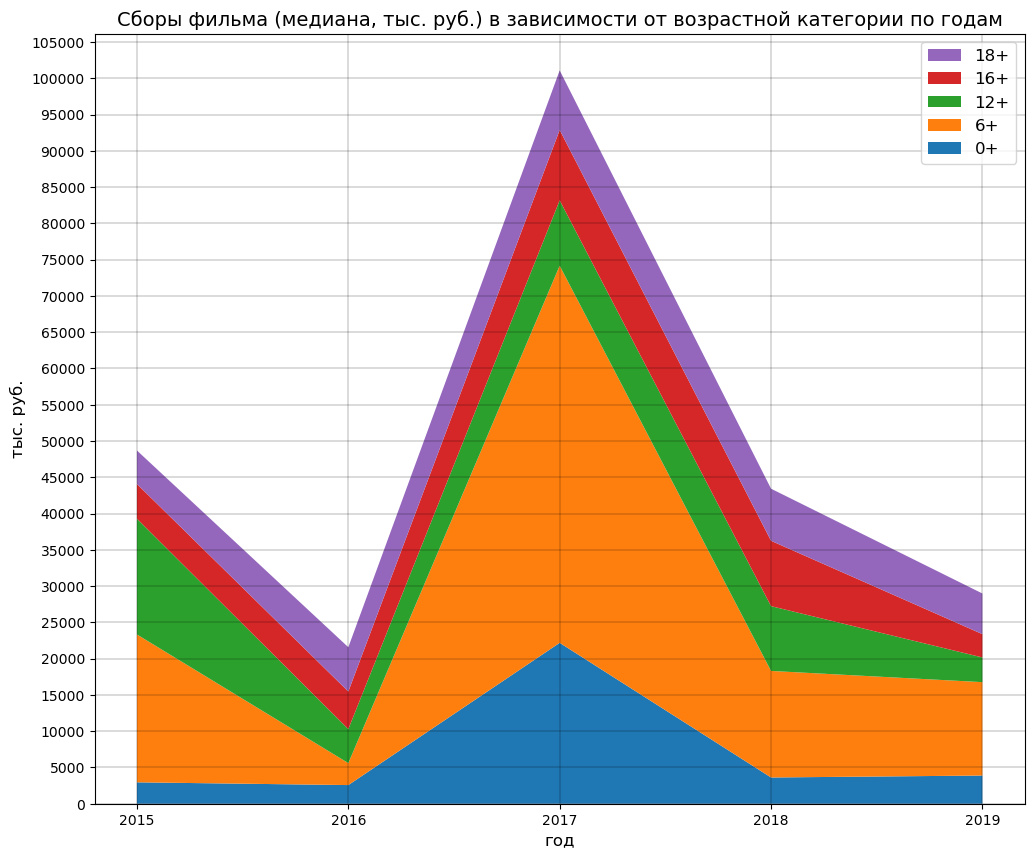

In [114]:
x = age_box_per_year.index
y0 = age_box_per_year['0+']
y6 = age_box_per_year['6+']
y12 = age_box_per_year['12+']
y16 = age_box_per_year['16+']
y18 = age_box_per_year['18+']

fig, ax = plt.subplots()

ax.stackplot(x, [y0, y6, y12, y16, y18], labels = ['0+', '6+', '12+', '16+', '18+'])

current_handles, current_labels = plt.gca().get_legend_handles_labels()
reversed_handles = list(reversed(current_handles))
reversed_labels = list(reversed(current_labels))
ax.legend(reversed_handles, reversed_labels, fontsize='large')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))

ax.grid(which='major',
        color = 'k', 
        linewidth = .2)

ax.set_title('Сборы фильма (медиана, тыс. руб.) в зависимости от возрастной категории по годам', fontsize=14)
ax.set_xlabel('год', fontsize = 12)
ax.set_ylabel('тыс. руб.', fontsize = 12)

fig.set_figwidth(12)
fig.set_figheight(10)


plt.show()

Для ответа на вопрос **"Фильмы с каким возрастным ограничением собрали больше всего денег в прокате?"** построим сводную таблицу для периода (2015 - 2019) по солбцам, группировки сделаем по возрастным ограничениям, аггрегирующую функцию укажем `sum` и добавим параметр `margins`. Значения сборов будем отражать в млн. руб. Затем выведем получившийся датафрейм (без последней строки), упорядочив по значению `Total`

In [115]:
# значения в млн. руб.

age_box_total = pd.pivot_table(
    data=data_fltr[ (data_fltr['box_office']>0) & (data_fltr['show_start_year']>2014) ],
    index='age_restriction',
    columns = 'show_start_year',
    values = 'box_office',
    aggfunc=(lambda x: (sum(x)/1000000)),
    margins=True,
    margins_name='Total'
)[:-1]

age_box_total.rename(index={'«0+» - для любой зрительской аудитории': '0+',
                            '«6+» - для детей старше 6 лет' : '6+',
                            '«12+» - для детей старше 12 лет' :'12+',
                            '«16+» - для детей старше 16 лет' : '16+',
                            '«18+» - запрещено для детей' : '18+'
                           },
                     inplace=True)

age_box_total.sort_values('Total', ascending=False)

show_start_year,2015,2016,2017,2018,2019,Total
age_restriction,,,,,,
16+,11368.12,16664.55,18745.04,16503.60,12753.42,76034.73
12+,13616.08,12204.45,7851.43,14267.29,12680.20,60619.45
6+,8701.80,12053.15,12086.14,10104.97,12852.55,55798.61
18+,5432.31,6793.93,9651.50,8760.09,10121.80,40759.62
0+,379.05,150.23,229.60,32.45,17.75,809.08


Если говорить о сборах в целом за период 2015-2019, то эта цифра видна из таблицы: больше всех собрали фильмы в категории `16+`, за весь период с 2015 по 2019 год они собрали 76034 млн. руб сборов. А как дело обстоит в рамках каждого года?

Для ответа на вопрос **"как меняется картина в зависимости от года"** надо посмотреть сборы в каждой из категорий по годам.

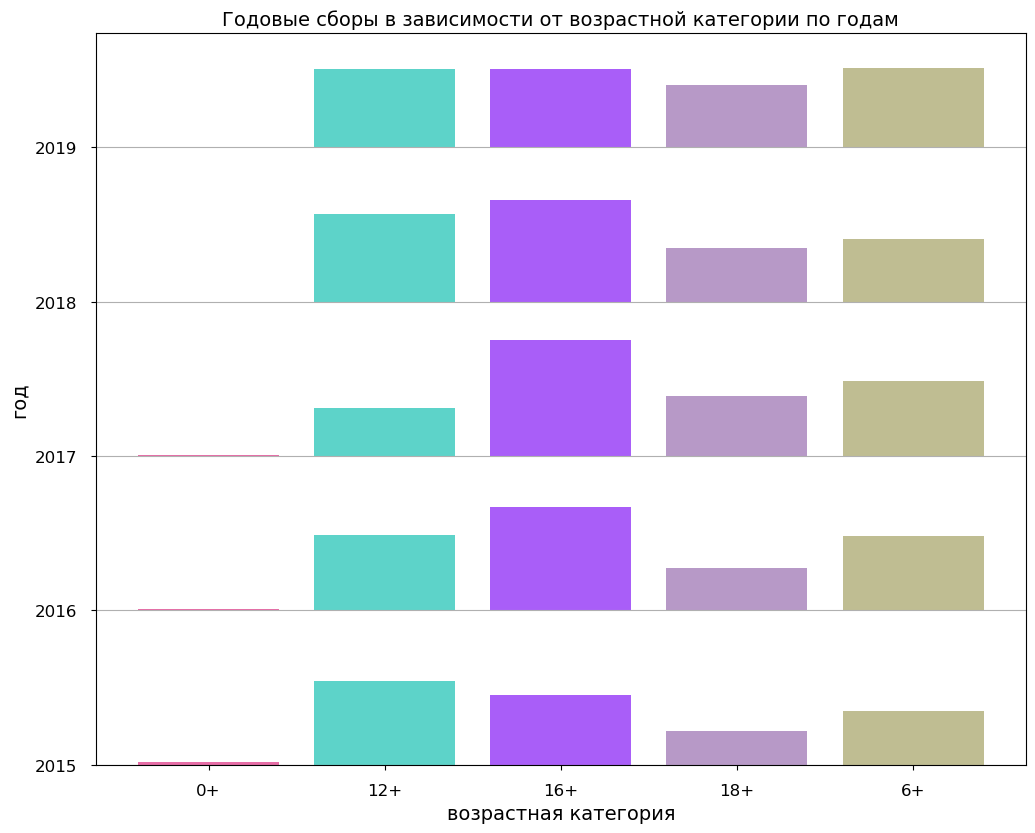

In [116]:
x = age_box_total.index
y15 = age_box_total[2015]/1000
y16 = age_box_total[2016]/1000
y17 = age_box_total[2017]/1000
y18 = age_box_total[2018]/1000
y19 = age_box_total[2019]/1000

fig, ax = plt.subplots()

colors = np.random.rand(10,3)

ax.bar(x, y15, color = colors)
ax.bar(x, y16, bottom = 25, color = colors)
ax.bar(x, y17, bottom = 50, color = colors)
ax.bar(x, y18, bottom = 75, color = colors)
ax.bar(x, y19, bottom = 100, color = colors)

ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
position = (0, 25, 50, 75, 100)
ax.set_yticks(position)
ax.set_yticklabels(age_box_total.columns[:-1])

ax.tick_params(axis = 'both',
               which = 'major',
               pad = 10,    
               labelsize = 12)

ax.set_title('Годовые сборы в зависимости от возрастной категории по годам', fontsize=14)
ax.set_xlabel('возрастная категория', fontsize=14)
ax.set_ylabel('год', fontsize=14)

ax.grid(axis = 'y')

fig.set_figwidth(12)
fig.set_figheight(9.5)


plt.show()

в 2015 году больше всех собрали фильмы `12+`, в период с 2016 по 2018 лучшие сборы показывали фильмы в категории `16+`. В 2019 категории `6+`, `12+` и `16+` показали практически одинаковые результаты по сборам. 

В 2017 году уверенное 2-е место по сборам было у категории `6+`. Также можно заметить, что сборы по категории `18+` стабильно растут год от года. Сборы по категории `0+` крайне малы на фоне остальных категорий и неуклонно снижались год от года.

Как менялся "чемпион" год от года по цифрам кумулятивных сборов (т.е. итоговых с начала рассматриваемого периода)? Для ответа на этот вопрос нам нужно посчитать накопившееся значения для каждого года (диапазон 2015 -2019) по сборам проката для каждой из возрастных категорий. Для начала модифицируем датафрейм `age_box_total`: транспонируем, избавимся от строки с `Total`

In [117]:
age_box_total = age_box_total.T[:-1]

In [118]:
age_box_total

age_restriction,0+,12+,16+,18+,6+
show_start_year,,,,,
2015,379.05,13616.08,11368.12,5432.31,8701.80
2016,150.23,12204.45,16664.55,6793.93,12053.15
2017,229.60,7851.43,18745.04,9651.50,12086.14
2018,32.45,14267.29,16503.60,8760.09,10104.97
2019,17.75,12680.20,12753.42,10121.80,12852.55


Найдем значение для каждого ряда, равное сумме предыдущего и текущего. Это будет давать нам кумулятивные значения проката по годам для каждой из возрастных категорийй.

In [119]:
for indx in range(1, len(age_box_total)):
    age_box_total.iloc[indx,:] = age_box_total.iloc[indx-1, :] + age_box_total.iloc[indx, :]

In [120]:
age_box_total

age_restriction,0+,12+,16+,18+,6+
show_start_year,,,,,
2015,379.05,13616.08,11368.12,5432.31,8701.80
2016,529.28,25820.53,28032.67,12226.24,20754.95
2017,758.88,33671.96,46777.71,21877.73,32841.09
2018,791.33,47939.25,63281.31,30637.82,42946.06
2019,809.08,60619.45,76034.73,40759.62,55798.61


Теперь можно построить графики по годам и посмотреть как менялся "чемпион" по накопленным прокатным сборам (какой из графиков "выше"):

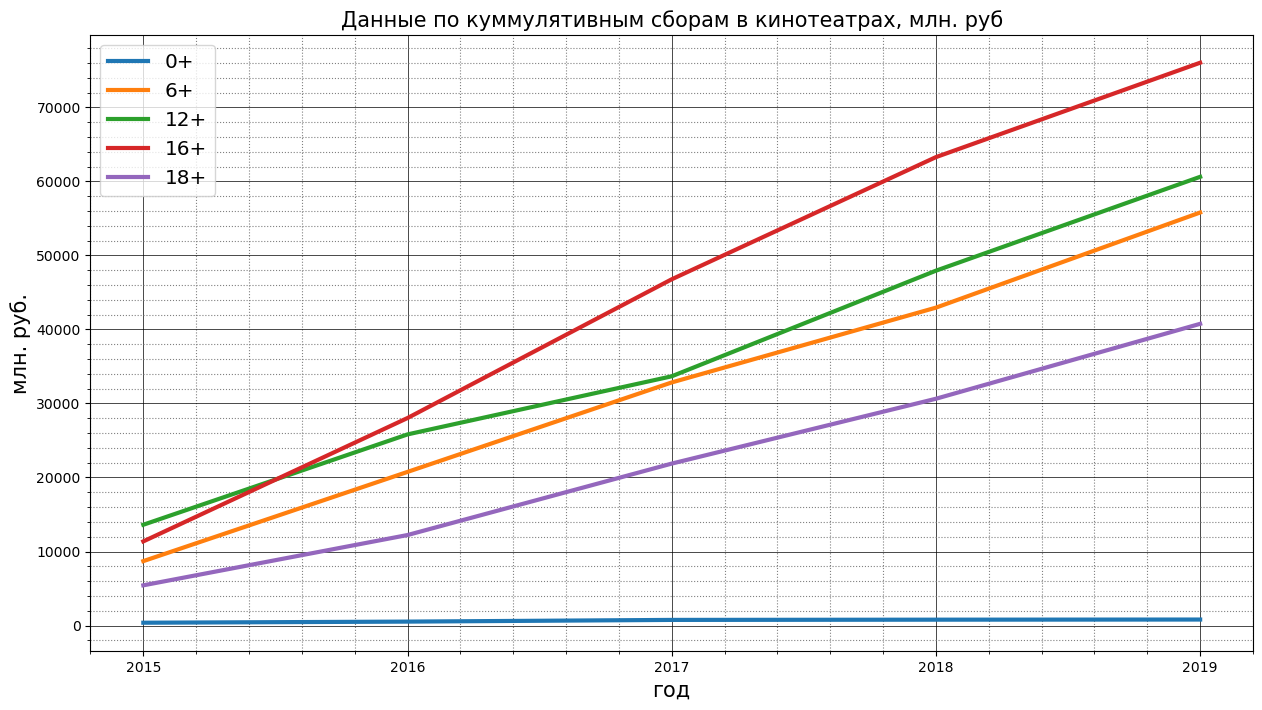

In [121]:
fig, ax = plt.subplots()

x = age_box_total.index
y0 = age_box_total['0+']
y6 = age_box_total['6+']
y12 = age_box_total['12+']
y16 = age_box_total['16+']
y18 = age_box_total['18+']

ax.plot(x, y0, linewidth = 3, label='0+')
ax.plot(x, y6, linewidth = 3,  label='6+')
ax.plot(x, y12, linewidth = 3,  label='12+')
ax.plot(x, y16, linewidth = 3,  label='16+')
ax.plot(x, y18, linewidth = 3,  label='18+')

ax.legend(fontsize='x-large')

ax.minorticks_on()

ax.grid(which='major',
        color = 'k', 
        linewidth = .5)

ax.grid(which='minor', 
        color = 'grey', 
        linestyle = ':')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_title('Данные по куммулятивным сборам в кинотеатрах, млн. руб', fontsize=15)
ax.set_xlabel('год', fontsize = 15)
ax.set_ylabel('млн. руб.', fontsize = 15)

fig.set_figwidth(15) 
fig.set_figheight(8)

plt.show()

##### Вывод

Вопрос: **"Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год?"**

Как видим из графика `"Сборы фильма (медиана, тыс. руб.) в зависимости от возрастной категории по годам"`, медианное значение сборов по фильму сильно зависело от возрастной категории для `0+` и `6+`. "Толщина" слоя показывет как менялось медианное значение сборов для фильма, относящегося к определенной возрастной категори и наибольший эффект виден именно для категорий `0+` и `6+`. Медианное значение сборов для этой категории было минимальным в 2016 и максимальным в 2017. Значение сборов для фильмов остальных категоррий изменяется по годам не так значительно.


Вопрос: **"Фильмы с каким возрастным ограничением собрали больше всего денег в прокате?"**

За период с 2015 по 2019 максимальные суммарные сборы у фильмов в категории `16+`, на втором месте `12+`, на третьем `6+`, далее слудуют `18+` и `0+`


Вопрос: **"Как меняется картина в зависимости от года?"**

В разрезе ежегодных сборов в 2015 году больше всех собрали фильмы `12+`, в период с 2016 по 2018 лучшие сборы показывали фильмы в категории `16+`. В 2019 категории `6+`, `12+` и `16+` показали практически одинаковые результаты по сборам. 
В 2017 году уверенное 2-е место по сборам было у категории `6+`. Также можно заметить, что сборы по категории `18+` стабильно растут год от года. Сборы по категории `0+` крайне малы на фоне остальных категорий и неуклонно снижались год от года.


Места по кумулятивным сборам в возрастных группах остаются стабильными на всем периоде 2015-2019, за исключением категорий `12+`и `16+` в 2015 и 2016 годах. В 2015 на 1-м месте по сборам были фильмы в категории `12+`, на втором `16+`. В 2016 категории поменялись местами. По остальным категориям изменений мест по сборам не происходило.


### Исследование фильмов, которые получили государственную поддержку

- Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

Рамер средств, выделяемых на поддержку, в бюджетах фильмов мы исследовали в разделе [4.0.1](#gov_supp)

Исследуем окупаемость фильмов, получивших средства гос. поддержки. Выделим данные, для которых есть информация по господдержке:

In [122]:
data_gov = data_fltr[data_fltr['budget'] > 0]

Введем новые столбцы:

- `gov_support_prcnt` - % гос. поддержки;
- `roi` - окупаемость (сборы / бюджет)

In [123]:
data_gov = data_gov.assign(
    gov_support_prcnt = lambda df: round(
        ((df['refundable_support'] + df['nonrefundable_support']) / df['budget'] * 100),
        2,
    )
)

data_gov = data_gov.assign(roi = lambda df: round((df['box_office'] / df['budget']), 2))

**ВОПРОС:** Сколько фильмов окупилось из числа получивших определенный % господдержки (т.е. `roi` > 1)? 

In [124]:
def count_more_1(itrble):
    # счетчик по условию (считает значения >= 1)
    counter = []
    itrble.apply(lambda x: counter.append(True) if x >= 1 else counter.append(False))
    return sum(counter)

def count_less_1(itrble):
    # счетчик по условию (считает значения < 1)
    counter = []
    itrble.apply(lambda x: counter.append(True) if x < 1 else counter.append(False))
    return sum(counter)

In [125]:
roi_total_succ = (
    data_gov.groupby(pd.cut(data_gov['gov_support_prcnt'], [0, 10, 25, 50, 75, 90, 100]))
    .agg(total_qty=('roi', 'count'), success_qty=('roi', count_more_1) )
    .assign(succ_prcnt = (lambda df: df['success_qty']/df['total_qty']*100))
)

roi_total_succ['success_qty'] = roi_total_succ['success_qty'].apply(lambda ser: int(ser))
display(roi_total_succ)

,total_qty,success_qty,succ_prcnt
gov_support_prcnt,,,
"(0, 10]",4,0,0.00
"(10, 25]",25,6,24.00
"(25, 50]",95,27,28.42
"(50, 75]",190,33,17.37
"(75, 90]",1,0,0.00
"(90, 100]",17,13,76.47


**ОТВЕТ:** Как видим, окупаемость не слишком большая. Только в группе получившей от 90% господдержки окупаемость удовлетворительная. По остальным группам - даже до половины не дотягивает.

**ВОПРОС:** Какому числу фильмов, которые не окупились, удалось хотя бы собрать `box_office` в размере не менее возвратной части господдержки `refundable_support`?

In [126]:
data_gov = data_gov.assign(refsup_roi = lambda df: df['box_office']/df['refundable_support'])

roi_total_fail = (
    data_gov
    .groupby(pd.cut(data_gov['gov_support_prcnt'], [0, 10, 25, 50, 75, 90, 100]))
    .agg(total_qty=('roi', 'count'), failed_qty=('roi', count_less_1), refsup_return_qty = ('refsup_roi', count_more_1) )
    .assign(refsup_return_prcnt = (lambda df: df['refsup_return_qty']/df['failed_qty']*100))
)

roi_total_fail['failed_qty'] = roi_total_fail['failed_qty'].apply(lambda ser: int(ser))
display(roi_total_fail)

,total_qty,failed_qty,refsup_return_qty,refsup_return_prcnt
gov_support_prcnt,,,,
"(0, 10]",4,4,3,75.00
"(10, 25]",25,19,23,121.05
"(25, 50]",95,68,88,129.41
"(50, 75]",190,157,161,102.55
"(75, 90]",1,1,0,0.00
"(90, 100]",17,4,17,425.00


**ОТВЕТ:** В таком разрезе картина чуть оптимистичней: единственный фильм из группы получившей от 75% до 90% господдержки не смог показать сборы даже в объеме возвратной части. В группе фильмов, получивших до 10% господдержки, только 1 фильм не смог набрать минимум сборов, чтоб покрыть объём возвратных средств государственной поддержки. По остальным группам все "провалившиеся" фильмы смогли собрать объём возвратных средств государственной поддержки.

**ВОПРОС:** Зависит ли рейтинг фильма от размера господдержки и бюджета?

Посмотрим зависимость с помощью `heatmap`

In [127]:
rating_budg_supp = pd.pivot_table(
    data=data_gov,
    index=pd.qcut(data_gov['gov_support_prcnt'], q=7),
    columns = pd.qcut(data_gov['budget'], q=7),
    values = 'ratings',
    aggfunc = ({'ratings' : 'median'})
).sort_index(ascending=False)

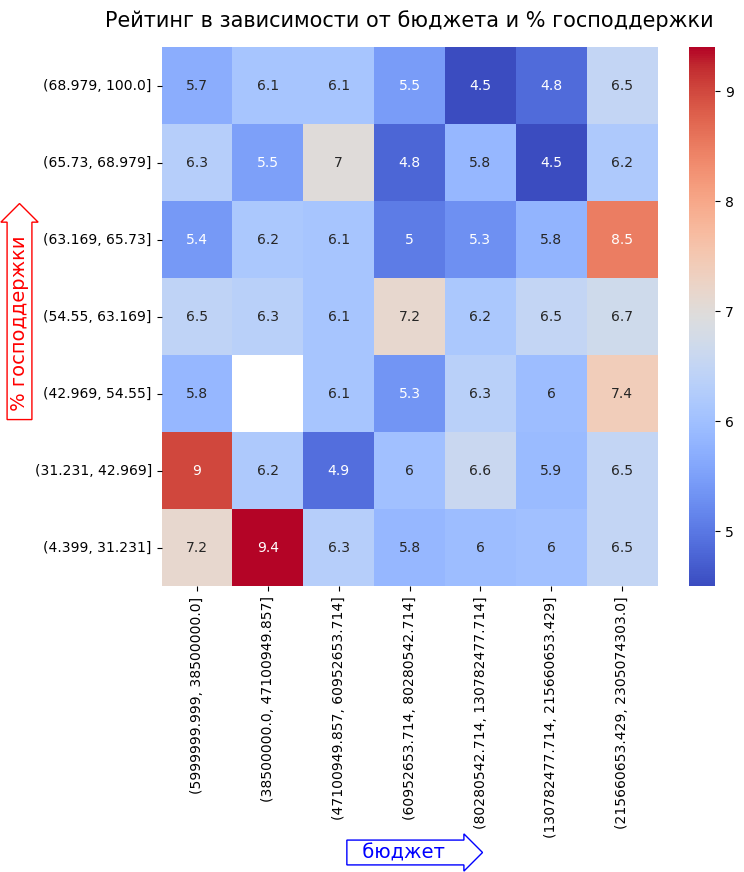

In [128]:
fig, ax = plt.subplots()
sns.heatmap(rating_budg_supp, annot=True, cmap='coolwarm')
ax.set_title('Рейтинг в зависимости от бюджета и % господдержки', fontsize=15, pad=15)

ax.set_xlabel('  бюджет    ',
              fontsize = 14,   
              color = 'blue',
              bbox = {'boxstyle': 'rarrow',
                      'pad': 0.15,
                      'facecolor': 'white',
                      'edgecolor': 'blue',
                      'linewidth': 1})

ax.set_ylabel(' % господдержки   ',
              fontsize = 14,
              color = 'red',
              bbox = {'boxstyle': 'rarrow',
                      'pad': 0.15,
                      'facecolor': 'white',
                      'edgecolor': 'red',
                      'linewidth': 1})

fig.set_figwidth(8) 
fig.set_figheight(7)

plt.show()

Для малобюджетных фильмов наблюдается обратная зависимость рейтинга от объема господдержки - это левый нижний угол, там рейтинги самые большие.

Построим корреляционную матрицу для выбранных значений:

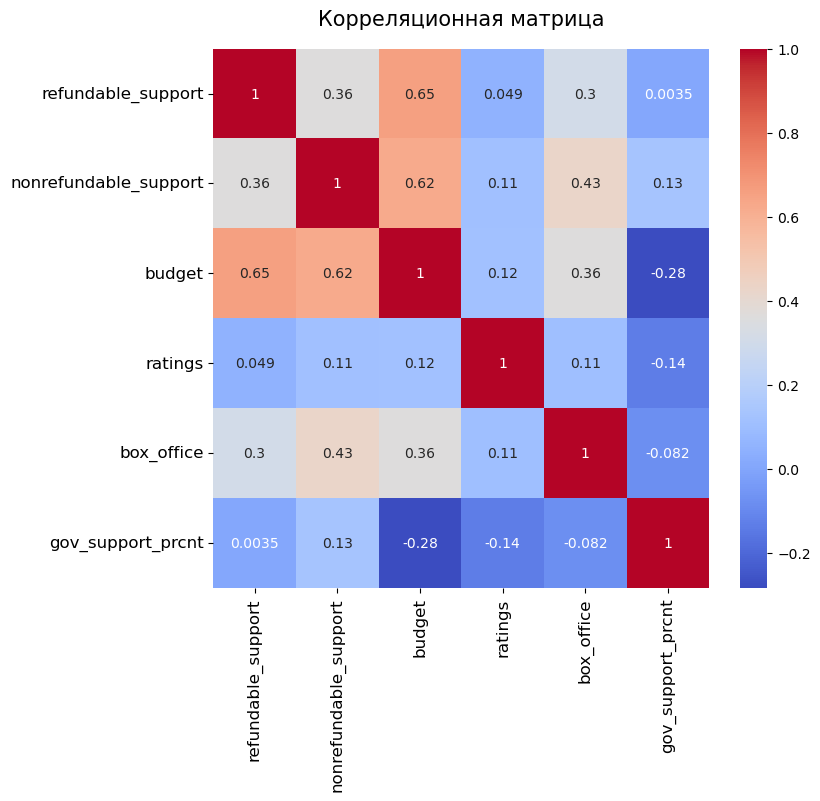

In [129]:
fig, ax = plt.subplots()
sns.heatmap(data_gov[['age_restriction',
                      'refundable_support',
                      'nonrefundable_support',
                      'budget',
                      'financing_source',
                      'ratings',
                      'genres_fltr',
                      'box_office',
                      'gov_support_prcnt']].corr(),
            annot=True,
            cmap='coolwarm'
           )

ax.set_title('Корреляционная матрица', fontsize=15, pad=17)
ax.tick_params(axis = 'both',       
               which = 'major',     
               labelsize = 12,      
               labelcolor = 'black',
               )    
fig.set_figwidth(8) 
fig.set_figheight(7)
plt.show()

**ОТВЕТ:** Явной зависимости рейтига от какого-то параметра не выявлено. Для малобюджетных фильмов зависимость от господдержки скорее обратная - чем меньше, тем выше рейтинг.

#### Вывод

Окупаемость фильмов с господдержкой в среднем не превышает 30%, однако почти все фильмы как минимум собирают в прокате объем возвратной части господдержки. Связи рейтинга фильма с размером господдержки и с бюджетом не выявлено. Для малобюджетных фильмов зависимость от господдержки скорее обратная - чем меньше, тем выше рейтинг.

### Общий вывод

Данные из переменных `data` и `data_show` объединены в один датафрейм `data` по значению номера прокатного удостоверения `pu_number`. Итоговый датафрейм содержит 7485 записей из 16 столбцов. Все строковые данные приведены к нижнему регистру, названия колонок соответствуют принятым правилам. Формат данных в столбце `show_start_date` изменен из типа `float` в тип `datetime` с округлением до дня, тип данных в столбце `pu_number` изменен со строкового на `int64`. В итоговом датафрейме 10 столбцов со строковыми данными типа `object`, 1 столбцец целого типа `int64`, 4 столбца с вещественными данными типа `float64` и 1 столбец с даннымыми формата `datetime`. В 11 столбцах есть пропуски данных.


Оптимизировали тип данных в столбце `pu_number` из `int64` в `uint32`. 
Вещественный тип `float64` в столбцах `box_office`, `budget`, `nonrefundable_support`, `refundable_support` изменили на целочисленный беззнаковый `uint32`
Строковые данные в столбце `raitings` привели к вещественному типу `float64`
Размер датафрейма уменьшился: с 994.1+ до 847.9+ KB

Заполнены все пропуски.
Пропуски (7153) в столбце `financing_source` заполнены значением `"отсутствует"`;
Пропуски (975) в столбце `genres` заполнены значением `"нет данных"`;
Пропуски в столбцах `film_studio` (18),  `production_country`(2)  заполнены значением `"нет данных"`;
Пропуски в столбцах `box_office`, `budget`, `nonrefundable_support`, `refundable_support` заполнены значнием `0` (см. [раздел 3.1.2](#3_1_2))
Пропуски в столбце `producer` (564 / 568) заполнили данными из `director`. Пропуски в столбце `director` (5 / 9) заполнили данными из `producer`.Оставшиеся пропуски в `producer` (4) и `director` (4) заполнили значением `"нет данных"`
Пропуски в столбце `ratings` (966)  заполнили значением `0`.


Явных дубликатов не обнаружено.

Неявные дубликаты:
- 8 фильмов отличаются только номером прокатного удостоверения. Прокатное удостоверение выдается конкретному заявителю (физ. или юр. лицо) и дает право на прокат фильма. Такие неявные дубликаты оставляем.
- 499 фильмов отличается датами премьеры и номерами прокатных удостоверений (т.к. исключение только `show_start_date` без исключения `pu_number` не приводит к дубликатам). Вероятно, дата премьеры - это дата начала проката при получении прокатного удостоверения. Поэтому разные заявители получали на один и тот же фильм прокатное удостоверение с разной датой начала проката. Такие неявные дубликаты оставляем.
- 5 фильмов имеют разные категории возрастного ограничения. Оставляем, так как не понятно: это ошибки в данных или это разные версии фильма.
- 181 фильм отличается данными по сборам в кинотеатрах. Это вызвано тем, что сборы указываются для конкретного номера прокатного удостоверения. Один и тот же фильм мог получать разные прокатные удостоврения в разные года и показывать разные сборы в кинотеатрах в период действия этого прокатного удостоверения.


В рамках исследовательского анализа изучено:
- кол-во фильмов в прокате по годам [4.1](#4_1)
- динамика проката по годам [4.2](#4_2)
- среднее и медианное значение сборов по годам [4.3](#4_3)
- зависимость сборов от возрастной категории. Как по годам так и в целом за период 2015-2019 [4.4](#4_4)

Проведено краткое исследование фильмов, получивших господдержку. 
Окупаемость фильмов с господдержкой в среднем не превышает 30%, однако почти все фильмы как минимум собирают в прокате объем возвратной части господдержки. Связи рейтинга фильма с размером господдержки и с бюджетом не выявлено. Для малобюджетных фильмов зависимость от господдержки скорее обратная - чем меньше, тем выше рейтинг.